##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# 画像分類器を再トレーニングする


<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_image_retraining">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org で表示</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colabで実行</a>
</td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
  <td><a href="https://tfhub.dev/google/collections/image/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png"> TF Hub モデルを参照</a></td>
</table>

## はじめに

画像分類モデルには数百個のパラメータがあります。モデルをゼロからトレーニングするには、ラベル付きの多数のトレーニングデータと膨大なトレーニング性能が必要となります。転移学習とは、関連するタスクでトレーニングされたモデルの一部を取り出して新しいモデルで再利用することで、学習の大部分を省略するテクニックを指します。

この Colab では、より大規模で一般的な ImageNet データセットでトレーニングされた、TensorFlow Hub のトレーニング済み TF2 SavedModel を使用して画像特徴量を抽出することで、5 種類の花を分類する Keras モデルの構築方法を実演します。オプションとして、特徴量抽出器を新たに追加される分類器とともにトレーニング（「ファインチューニング」）することができます。

### 代替ツールをお探しですか？

これは、TensorFlow のコーディングチュートリアルです。TensorFlow または TF Lite モデルを構築するだけのツールをお探しの方は、PIP パッケージ `tensorflow-hub[make_image_classifier]` によって[インストールされる](https://www.tensorflow.org/hub/installation) [make_image_classifier](https://github.com/tensorflow/hub/tree/master/tensorflow_hub/tools/make_image_classifier) コマンドラインツール、または[こちら](https://colab.sandbox.google.com/github/tensorflow/examples/blob/master/tensorflow_examples/lite/model_maker/demo/image_classification.ipynb)の TF Lite Colab をご覧ください。


## セットアップ

In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

2024-01-11 19:59:24.086086: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 19:59:24.086129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 19:59:24.087797: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF version: 2.15.0
Hub version: 0.15.0
GPU is available


## 使用する TF2 SavedModel モジュールを選択する

手始めに、[https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4) を使用します。同じ URL を、SavedModel を識別するコードに使用できます。またブラウザで使用すれば、そのドキュメントを表示することができます。（ここでは TF1 Hub 形式のモデルは機能しないことに注意してください。）

画像特徴量ベクトルを生成するその他の TF2 モデルは、[こちら](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2)をご覧ください。

試すことのできるモデルはたくさんあります。下のセルから別のモデルを選択し、ノートブックの指示に従ってください。

In [3]:
#@title

model_name = "efficientnetv2-xl-21k" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16#@param {type:"integer"}

Selected model: efficientnetv2-xl-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2
Input size (512, 512)


## Flowers データセットをセットアップする

入力は、選択されたモジュールに合わせてサイズ変更されます。データセットを拡張することで（読み取られるたびに画像をランダムに歪みを加える）、特にファインチューニング時のトレーニングが改善されます。

In [4]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

     8192/228813984 [..............................] - ETA: 0s

  7585792/228813984 [..............................] - ETA: 1s

 17588224/228813984 [=>............................] - ETA: 1s

 24477696/228813984 [==>...........................] - ETA: 1s

 30826496/228813984 [===>..........................] - ETA: 1s

 37011456/228813984 [===>..........................] - ETA: 1s

 50372608/228813984 [=====>........................] - ETA: 1s

 65626112/228813984 [=======>......................] - ETA: 0s

 76406784/228813984 [=========>....................] - ETA: 0s

 89653248/228813984 [==========>...................] - ETA: 0s

102326272/228813984 [============>.................] - ETA: 0s

115802112/228813984 [==============>...............] - ETA: 0s

131383296/228813984 [================>.............] - ETA: 0s

147111936/228813984 [==================>...........] - ETA: 0s

161415168/228813984 [====================>.........] - ETA: 0s

175783936/228813984 [======================>.......] - ETA: 0s

190234624/228813984 [=======================>......] - ETA: 0s

205586432/228813984 [=========================>....] - ETA: 0s

221061120/228813984 [===========================>..] - ETA: 0s

228813984/228813984 [==============================] - 1s 0us/step


In [5]:
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 3670 files belonging to 5 classes.


Using 2936 files for training.


Found 3670 files belonging to 5 classes.


Using 734 files for validation.


## モデルを定義する

Hub モジュールを使用して、線形分類器を `feature_extractor_layer` の上に配置するだけで定義できます。

高速化するため、トレーニング不可能な `feature_extractor_layer` から始めますが、ファインチューニングを実施して精度を高めることもできます。

In [6]:
do_fine_tuning = False #@param {type:"boolean"}

In [7]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 keras_layer (KerasLayer)    (None, 1280)              207615832 


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 5)                 6405      


Total params: 207622237 (792.02 MB)


Trainable params: 6405 (25.02 KB)


Non-trainable params: 207615832 (791.99 MB)


_________________________________________________________________


## モデルをトレーニングする

In [8]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [9]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/5


  1/183 [..............................] - ETA: 1:52:17 - loss: 2.6761 - accuracy: 0.1875

I0000 00:00:1705003243.156430  162420 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  2/183 [..............................] - ETA: 3:33 - loss: 2.3936 - accuracy: 0.1875   

  3/183 [..............................] - ETA: 3:32 - loss: 2.1877 - accuracy: 0.2708

  4/183 [..............................] - ETA: 3:31 - loss: 2.1239 - accuracy: 0.3438

  5/183 [..............................] - ETA: 3:30 - loss: 2.0526 - accuracy: 0.3750

  6/183 [..............................] - ETA: 3:29 - loss: 1.9051 - accuracy: 0.4375

  7/183 [>.............................] - ETA: 3:28 - loss: 1.8503 - accuracy: 0.4554

  8/183 [>.............................] - ETA: 3:27 - loss: 1.7380 - accuracy: 0.5000

  9/183 [>.............................] - ETA: 3:26 - loss: 1.6582 - accuracy: 0.5278

 10/183 [>.............................] - ETA: 3:25 - loss: 1.6010 - accuracy: 0.5500

 11/183 [>.............................] - ETA: 3:24 - loss: 1.5546 - accuracy: 0.5739

 12/183 [>.............................] - ETA: 3:22 - loss: 1.4906 - accuracy: 0.6094

 13/183 [=>............................] - ETA: 3:21 - loss: 1.4400 - accuracy: 0.6346

 14/183 [=>............................] - ETA: 3:20 - loss: 1.4157 - accuracy: 0.6473

 15/183 [=>............................] - ETA: 3:19 - loss: 1.3992 - accuracy: 0.6667

 16/183 [=>............................] - ETA: 3:18 - loss: 1.3731 - accuracy: 0.6875

 17/183 [=>............................] - ETA: 3:17 - loss: 1.3437 - accuracy: 0.7059

 18/183 [=>............................] - ETA: 3:16 - loss: 1.3124 - accuracy: 0.7222

 19/183 [==>...........................] - ETA: 3:15 - loss: 1.2985 - accuracy: 0.7368

 20/183 [==>...........................] - ETA: 3:14 - loss: 1.2904 - accuracy: 0.7437

 21/183 [==>...........................] - ETA: 3:12 - loss: 1.2739 - accuracy: 0.7560

 22/183 [==>...........................] - ETA: 3:11 - loss: 1.2563 - accuracy: 0.7670

 23/183 [==>...........................] - ETA: 3:10 - loss: 1.2600 - accuracy: 0.7717

 24/183 [==>...........................] - ETA: 3:09 - loss: 1.2523 - accuracy: 0.7786

 25/183 [===>..........................] - ETA: 3:08 - loss: 1.2628 - accuracy: 0.7800

 26/183 [===>..........................] - ETA: 3:07 - loss: 1.2536 - accuracy: 0.7885

 27/183 [===>..........................] - ETA: 3:06 - loss: 1.2622 - accuracy: 0.7894

 28/183 [===>..........................] - ETA: 3:05 - loss: 1.2619 - accuracy: 0.7946

 29/183 [===>..........................] - ETA: 3:04 - loss: 1.2516 - accuracy: 0.7996

 30/183 [===>..........................] - ETA: 3:03 - loss: 1.2383 - accuracy: 0.8062

 31/183 [====>.........................] - ETA: 3:01 - loss: 1.2280 - accuracy: 0.8125

 32/183 [====>.........................] - ETA: 3:00 - loss: 1.2199 - accuracy: 0.8184

 33/183 [====>.........................] - ETA: 2:59 - loss: 1.2094 - accuracy: 0.8239

 34/183 [====>.........................] - ETA: 2:58 - loss: 1.2055 - accuracy: 0.8254

 35/183 [====>.........................] - ETA: 2:57 - loss: 1.2019 - accuracy: 0.8268

 36/183 [====>.........................] - ETA: 2:56 - loss: 1.1908 - accuracy: 0.8316

 37/183 [=====>........................] - ETA: 2:55 - loss: 1.1877 - accuracy: 0.8294

 38/183 [=====>........................] - ETA: 2:54 - loss: 1.1860 - accuracy: 0.8322

 39/183 [=====>........................] - ETA: 2:53 - loss: 1.1781 - accuracy: 0.8349

 40/183 [=====>........................] - ETA: 2:51 - loss: 1.1694 - accuracy: 0.8375

 41/183 [=====>........................] - ETA: 2:50 - loss: 1.1743 - accuracy: 0.8384

 42/183 [=====>........................] - ETA: 2:49 - loss: 1.1707 - accuracy: 0.8393

 43/183 [======>.......................] - ETA: 2:48 - loss: 1.1752 - accuracy: 0.8401

 44/183 [======>.......................] - ETA: 2:47 - loss: 1.1655 - accuracy: 0.8438

 45/183 [======>.......................] - ETA: 2:46 - loss: 1.1587 - accuracy: 0.8444

 46/183 [======>.......................] - ETA: 2:45 - loss: 1.1516 - accuracy: 0.8465

 47/183 [======>.......................] - ETA: 2:44 - loss: 1.1564 - accuracy: 0.8471

 48/183 [======>.......................] - ETA: 2:43 - loss: 1.1524 - accuracy: 0.8464

 49/183 [=======>......................] - ETA: 2:41 - loss: 1.1453 - accuracy: 0.8469

 50/183 [=======>......................] - ETA: 2:40 - loss: 1.1397 - accuracy: 0.8487

 51/183 [=======>......................] - ETA: 2:39 - loss: 1.1350 - accuracy: 0.8480

 52/183 [=======>......................] - ETA: 2:38 - loss: 1.1287 - accuracy: 0.8498

 53/183 [=======>......................] - ETA: 2:37 - loss: 1.1206 - accuracy: 0.8514

 54/183 [=======>......................] - ETA: 2:36 - loss: 1.1145 - accuracy: 0.8519

 55/183 [========>.....................] - ETA: 2:35 - loss: 1.1069 - accuracy: 0.8534

 56/183 [========>.....................] - ETA: 2:34 - loss: 1.0986 - accuracy: 0.8560

 57/183 [========>.....................] - ETA: 2:32 - loss: 1.0939 - accuracy: 0.8575

 58/183 [========>.....................] - ETA: 2:31 - loss: 1.0856 - accuracy: 0.8599

 59/183 [========>.....................] - ETA: 2:30 - loss: 1.0829 - accuracy: 0.8602

 60/183 [========>.....................] - ETA: 2:29 - loss: 1.0756 - accuracy: 0.8615

 61/183 [=========>....................] - ETA: 2:28 - loss: 1.0724 - accuracy: 0.8617

 62/183 [=========>....................] - ETA: 2:27 - loss: 1.0774 - accuracy: 0.8609

 63/183 [=========>....................] - ETA: 2:26 - loss: 1.0780 - accuracy: 0.8611

 64/183 [=========>....................] - ETA: 2:24 - loss: 1.0724 - accuracy: 0.8613

 65/183 [=========>....................] - ETA: 2:23 - loss: 1.0647 - accuracy: 0.8635

 66/183 [=========>....................] - ETA: 2:22 - loss: 1.0634 - accuracy: 0.8627

 67/183 [=========>....................] - ETA: 2:21 - loss: 1.0592 - accuracy: 0.8629

 68/183 [==========>...................] - ETA: 2:20 - loss: 1.0583 - accuracy: 0.8631

 69/183 [==========>...................] - ETA: 2:19 - loss: 1.0539 - accuracy: 0.8632

 70/183 [==========>...................] - ETA: 2:18 - loss: 1.0484 - accuracy: 0.8643

 71/183 [==========>...................] - ETA: 2:16 - loss: 1.0431 - accuracy: 0.8653

 72/183 [==========>...................] - ETA: 2:15 - loss: 1.0391 - accuracy: 0.8655

 73/183 [==========>...................] - ETA: 2:14 - loss: 1.0384 - accuracy: 0.8647

 74/183 [===========>..................] - ETA: 2:13 - loss: 1.0391 - accuracy: 0.8649

 75/183 [===========>..................] - ETA: 2:12 - loss: 1.0351 - accuracy: 0.8658

 76/183 [===========>..................] - ETA: 2:11 - loss: 1.0333 - accuracy: 0.8651

 77/183 [===========>..................] - ETA: 2:10 - loss: 1.0364 - accuracy: 0.8636

 78/183 [===========>..................] - ETA: 2:08 - loss: 1.0319 - accuracy: 0.8646

 79/183 [===========>..................] - ETA: 2:07 - loss: 1.0271 - accuracy: 0.8663

 80/183 [============>.................] - ETA: 2:06 - loss: 1.0224 - accuracy: 0.8680

 81/183 [============>.................] - ETA: 2:05 - loss: 1.0180 - accuracy: 0.8696

 82/183 [============>.................] - ETA: 2:04 - loss: 1.0132 - accuracy: 0.8712

 83/183 [============>.................] - ETA: 2:03 - loss: 1.0115 - accuracy: 0.8712

 84/183 [============>.................] - ETA: 2:01 - loss: 1.0089 - accuracy: 0.8720

 85/183 [============>.................] - ETA: 2:00 - loss: 1.0118 - accuracy: 0.8713

 86/183 [=============>................] - ETA: 1:59 - loss: 1.0098 - accuracy: 0.8706

 87/183 [=============>................] - ETA: 1:58 - loss: 1.0054 - accuracy: 0.8721

 88/183 [=============>................] - ETA: 1:57 - loss: 1.0010 - accuracy: 0.8736

 89/183 [=============>................] - ETA: 1:55 - loss: 0.9979 - accuracy: 0.8743

 90/183 [=============>................] - ETA: 1:54 - loss: 1.0029 - accuracy: 0.8722

 91/183 [=============>................] - ETA: 1:53 - loss: 1.0001 - accuracy: 0.8729

 92/183 [==============>...............] - ETA: 1:52 - loss: 1.0014 - accuracy: 0.8723

 93/183 [==============>...............] - ETA: 1:50 - loss: 0.9974 - accuracy: 0.8730

 94/183 [==============>...............] - ETA: 1:49 - loss: 0.9967 - accuracy: 0.8737

 95/183 [==============>...............] - ETA: 1:48 - loss: 0.9980 - accuracy: 0.8730

 96/183 [==============>...............] - ETA: 1:47 - loss: 0.9958 - accuracy: 0.8730

 97/183 [==============>...............] - ETA: 1:46 - loss: 0.9926 - accuracy: 0.8744

 98/183 [===============>..............] - ETA: 1:44 - loss: 0.9907 - accuracy: 0.8737

 99/183 [===============>..............] - ETA: 1:43 - loss: 0.9896 - accuracy: 0.8737

100/183 [===============>..............] - ETA: 1:42 - loss: 0.9862 - accuracy: 0.8750

101/183 [===============>..............] - ETA: 1:41 - loss: 0.9828 - accuracy: 0.8762

102/183 [===============>..............] - ETA: 1:40 - loss: 0.9808 - accuracy: 0.8768

103/183 [===============>..............] - ETA: 1:38 - loss: 0.9793 - accuracy: 0.8774

104/183 [================>.............] - ETA: 1:37 - loss: 0.9771 - accuracy: 0.8786

105/183 [================>.............] - ETA: 1:36 - loss: 0.9760 - accuracy: 0.8786

106/183 [================>.............] - ETA: 1:35 - loss: 0.9765 - accuracy: 0.8779

107/183 [================>.............] - ETA: 1:33 - loss: 0.9735 - accuracy: 0.8791

108/183 [================>.............] - ETA: 1:32 - loss: 0.9729 - accuracy: 0.8791

109/183 [================>.............] - ETA: 1:31 - loss: 0.9724 - accuracy: 0.8796

110/183 [=================>............] - ETA: 1:30 - loss: 0.9697 - accuracy: 0.8801

111/183 [=================>............] - ETA: 1:28 - loss: 0.9675 - accuracy: 0.8806

112/183 [=================>............] - ETA: 1:27 - loss: 0.9667 - accuracy: 0.8806

113/183 [=================>............] - ETA: 1:26 - loss: 0.9646 - accuracy: 0.8811

114/183 [=================>............] - ETA: 1:25 - loss: 0.9614 - accuracy: 0.8821

115/183 [=================>............] - ETA: 1:24 - loss: 0.9611 - accuracy: 0.8821

116/183 [==================>...........] - ETA: 1:22 - loss: 0.9583 - accuracy: 0.8831

117/183 [==================>...........] - ETA: 1:21 - loss: 0.9556 - accuracy: 0.8835

118/183 [==================>...........] - ETA: 1:20 - loss: 0.9524 - accuracy: 0.8845

119/183 [==================>...........] - ETA: 1:19 - loss: 0.9512 - accuracy: 0.8850

120/183 [==================>...........] - ETA: 1:17 - loss: 0.9521 - accuracy: 0.8839

121/183 [==================>...........] - ETA: 1:16 - loss: 0.9490 - accuracy: 0.8848

122/183 [===================>..........] - ETA: 1:15 - loss: 0.9485 - accuracy: 0.8842

123/183 [===================>..........] - ETA: 1:14 - loss: 0.9478 - accuracy: 0.8836

124/183 [===================>..........] - ETA: 1:12 - loss: 0.9465 - accuracy: 0.8831

125/183 [===================>..........] - ETA: 1:11 - loss: 0.9440 - accuracy: 0.8835

126/183 [===================>..........] - ETA: 1:10 - loss: 0.9420 - accuracy: 0.8839

127/183 [===================>..........] - ETA: 1:09 - loss: 0.9390 - accuracy: 0.8848

128/183 [===================>..........] - ETA: 1:08 - loss: 0.9373 - accuracy: 0.8843

129/183 [====================>.........] - ETA: 1:06 - loss: 0.9347 - accuracy: 0.8847

130/183 [====================>.........] - ETA: 1:05 - loss: 0.9344 - accuracy: 0.8851

131/183 [====================>.........] - ETA: 1:04 - loss: 0.9334 - accuracy: 0.8850

132/183 [====================>.........] - ETA: 1:03 - loss: 0.9306 - accuracy: 0.8859

133/183 [====================>.........] - ETA: 1:01 - loss: 0.9280 - accuracy: 0.8867

134/183 [====================>.........] - ETA: 1:00 - loss: 0.9267 - accuracy: 0.8871

135/183 [=====================>........] - ETA: 59s - loss: 0.9246 - accuracy: 0.8880 

136/183 [=====================>........] - ETA: 58s - loss: 0.9227 - accuracy: 0.8883

137/183 [=====================>........] - ETA: 56s - loss: 0.9245 - accuracy: 0.8869

138/183 [=====================>........] - ETA: 55s - loss: 0.9230 - accuracy: 0.8872

139/183 [=====================>........] - ETA: 54s - loss: 0.9211 - accuracy: 0.8876

140/183 [=====================>........] - ETA: 53s - loss: 0.9195 - accuracy: 0.8879

141/183 [======================>.......] - ETA: 52s - loss: 0.9216 - accuracy: 0.8870

142/183 [======================>.......] - ETA: 50s - loss: 0.9194 - accuracy: 0.8878

143/183 [======================>.......] - ETA: 49s - loss: 0.9191 - accuracy: 0.8877

144/183 [======================>.......] - ETA: 48s - loss: 0.9169 - accuracy: 0.8885

145/183 [======================>.......] - ETA: 47s - loss: 0.9165 - accuracy: 0.8875

146/183 [======================>.......] - ETA: 45s - loss: 0.9151 - accuracy: 0.8874

147/183 [=======================>......] - ETA: 44s - loss: 0.9131 - accuracy: 0.8882

148/183 [=======================>......] - ETA: 43s - loss: 0.9105 - accuracy: 0.8889

149/183 [=======================>......] - ETA: 42s - loss: 0.9081 - accuracy: 0.8897

150/183 [=======================>......] - ETA: 40s - loss: 0.9092 - accuracy: 0.8888

151/183 [=======================>......] - ETA: 39s - loss: 0.9079 - accuracy: 0.8895

152/183 [=======================>......] - ETA: 38s - loss: 0.9069 - accuracy: 0.8898

153/183 [========================>.....] - ETA: 37s - loss: 0.9070 - accuracy: 0.8897

154/183 [========================>.....] - ETA: 35s - loss: 0.9051 - accuracy: 0.8904

155/183 [========================>.....] - ETA: 34s - loss: 0.9030 - accuracy: 0.8911

156/183 [========================>.....] - ETA: 33s - loss: 0.9016 - accuracy: 0.8914

157/183 [========================>.....] - ETA: 32s - loss: 0.9015 - accuracy: 0.8913

158/183 [========================>.....] - ETA: 31s - loss: 0.8998 - accuracy: 0.8916

159/183 [=========================>....] - ETA: 29s - loss: 0.8977 - accuracy: 0.8923

160/183 [=========================>....] - ETA: 28s - loss: 0.8989 - accuracy: 0.8922

161/183 [=========================>....] - ETA: 27s - loss: 0.8985 - accuracy: 0.8917

162/183 [=========================>....] - ETA: 26s - loss: 0.8969 - accuracy: 0.8920

163/183 [=========================>....] - ETA: 24s - loss: 0.8972 - accuracy: 0.8907

164/183 [=========================>....] - ETA: 23s - loss: 0.9002 - accuracy: 0.8895

165/183 [==========================>...] - ETA: 22s - loss: 0.9009 - accuracy: 0.8894

166/183 [==========================>...] - ETA: 21s - loss: 0.8989 - accuracy: 0.8901

167/183 [==========================>...] - ETA: 19s - loss: 0.8977 - accuracy: 0.8903

168/183 [==========================>...] - ETA: 18s - loss: 0.8967 - accuracy: 0.8903

169/183 [==========================>...] - ETA: 17s - loss: 0.8958 - accuracy: 0.8905

170/183 [==========================>...] - ETA: 16s - loss: 0.8957 - accuracy: 0.8908

171/183 [===========================>..] - ETA: 14s - loss: 0.8943 - accuracy: 0.8911

172/183 [===========================>..] - ETA: 13s - loss: 0.8938 - accuracy: 0.8914

173/183 [===========================>..] - ETA: 12s - loss: 0.8924 - accuracy: 0.8916

174/183 [===========================>..] - ETA: 11s - loss: 0.8908 - accuracy: 0.8919

175/183 [===========================>..] - ETA: 9s - loss: 0.8891 - accuracy: 0.8925 

176/183 [===========================>..] - ETA: 8s - loss: 0.8892 - accuracy: 0.8920

177/183 [============================>.] - ETA: 7s - loss: 0.8883 - accuracy: 0.8923

178/183 [============================>.] - ETA: 6s - loss: 0.8865 - accuracy: 0.8929

179/183 [============================>.] - ETA: 4s - loss: 0.8869 - accuracy: 0.8928

180/183 [============================>.] - ETA: 3s - loss: 0.8861 - accuracy: 0.8927

181/183 [============================>.] - ETA: 2s - loss: 0.8850 - accuracy: 0.8926

182/183 [============================>.] - ETA: 1s - loss: 0.8856 - accuracy: 0.8922

183/183 [==============================] - ETA: 0s - loss: 0.8854 - accuracy: 0.8921

183/183 [==============================] - 323s 2s/step - loss: 0.8854 - accuracy: 0.8921 - val_loss: 0.7000 - val_accuracy: 0.9347


Epoch 2/5


  1/183 [..............................] - ETA: 15:13 - loss: 0.6558 - accuracy: 1.0000

  2/183 [..............................] - ETA: 3:46 - loss: 0.6903 - accuracy: 1.0000 

  3/183 [..............................] - ETA: 3:45 - loss: 0.6481 - accuracy: 1.0000

  4/183 [..............................] - ETA: 3:44 - loss: 0.6806 - accuracy: 0.9821

  5/183 [..............................] - ETA: 3:42 - loss: 0.7218 - accuracy: 0.9583

  6/183 [..............................] - ETA: 3:41 - loss: 0.7223 - accuracy: 0.9432

  7/183 [>.............................] - ETA: 3:40 - loss: 0.7047 - accuracy: 0.9519

  8/183 [>.............................] - ETA: 3:39 - loss: 0.7315 - accuracy: 0.9333

  9/183 [>.............................] - ETA: 3:37 - loss: 0.7471 - accuracy: 0.9265

 10/183 [>.............................] - ETA: 3:36 - loss: 0.7321 - accuracy: 0.9342

 11/183 [>.............................] - ETA: 3:35 - loss: 0.7239 - accuracy: 0.9405

 12/183 [>.............................] - ETA: 3:34 - loss: 0.7090 - accuracy: 0.9457

 13/183 [=>............................] - ETA: 3:33 - loss: 0.7106 - accuracy: 0.9450

 14/183 [=>............................] - ETA: 3:31 - loss: 0.7025 - accuracy: 0.9491

 15/183 [=>............................] - ETA: 3:30 - loss: 0.6916 - accuracy: 0.9526

 16/183 [=>............................] - ETA: 3:29 - loss: 0.6921 - accuracy: 0.9476

 17/183 [=>............................] - ETA: 3:28 - loss: 0.6834 - accuracy: 0.9508

 18/183 [=>............................] - ETA: 3:26 - loss: 0.6873 - accuracy: 0.9429

 19/183 [==>...........................] - ETA: 3:25 - loss: 0.6799 - accuracy: 0.9459

 20/183 [==>...........................] - ETA: 3:24 - loss: 0.6752 - accuracy: 0.9455

 21/183 [==>...........................] - ETA: 3:23 - loss: 0.6716 - accuracy: 0.9482

 22/183 [==>...........................] - ETA: 3:21 - loss: 0.6779 - accuracy: 0.9448

 23/183 [==>...........................] - ETA: 3:20 - loss: 0.6752 - accuracy: 0.9444

 24/183 [==>...........................] - ETA: 3:19 - loss: 0.6726 - accuracy: 0.9468

 25/183 [===>..........................] - ETA: 3:18 - loss: 0.6698 - accuracy: 0.9490

 26/183 [===>..........................] - ETA: 3:16 - loss: 0.6665 - accuracy: 0.9510

 27/183 [===>..........................] - ETA: 3:15 - loss: 0.6667 - accuracy: 0.9505

 28/183 [===>..........................] - ETA: 3:14 - loss: 0.6632 - accuracy: 0.9523

 29/183 [===>..........................] - ETA: 3:13 - loss: 0.6614 - accuracy: 0.9539

 30/183 [===>..........................] - ETA: 3:11 - loss: 0.6616 - accuracy: 0.9534

 31/183 [====>.........................] - ETA: 3:10 - loss: 0.6602 - accuracy: 0.9529

 32/183 [====>.........................] - ETA: 3:09 - loss: 0.6593 - accuracy: 0.9544

 33/183 [====>.........................] - ETA: 3:08 - loss: 0.6564 - accuracy: 0.9558

 34/183 [====>.........................] - ETA: 3:06 - loss: 0.6557 - accuracy: 0.9552

 35/183 [====>.........................] - ETA: 3:05 - loss: 0.6546 - accuracy: 0.9547

 36/183 [====>.........................] - ETA: 3:04 - loss: 0.6604 - accuracy: 0.9507

 37/183 [=====>........................] - ETA: 3:03 - loss: 0.6578 - accuracy: 0.9521

 38/183 [=====>........................] - ETA: 3:01 - loss: 0.6561 - accuracy: 0.9533

 39/183 [=====>........................] - ETA: 3:00 - loss: 0.6553 - accuracy: 0.9545

 40/183 [=====>........................] - ETA: 2:59 - loss: 0.6546 - accuracy: 0.9541

 41/183 [=====>........................] - ETA: 2:58 - loss: 0.6548 - accuracy: 0.9537

 42/183 [=====>........................] - ETA: 2:56 - loss: 0.6560 - accuracy: 0.9533

 43/183 [======>.......................] - ETA: 2:55 - loss: 0.6561 - accuracy: 0.9529

 44/183 [======>.......................] - ETA: 2:54 - loss: 0.6549 - accuracy: 0.9526

 45/183 [======>.......................] - ETA: 2:53 - loss: 0.6580 - accuracy: 0.9522

 46/183 [======>.......................] - ETA: 2:51 - loss: 0.6611 - accuracy: 0.9492

 47/183 [======>.......................] - ETA: 2:50 - loss: 0.6584 - accuracy: 0.9503

 48/183 [======>.......................] - ETA: 2:49 - loss: 0.6642 - accuracy: 0.9500

 49/183 [=======>......................] - ETA: 2:48 - loss: 0.6618 - accuracy: 0.9510

 50/183 [=======>......................] - ETA: 2:46 - loss: 0.6666 - accuracy: 0.9508

 51/183 [=======>......................] - ETA: 2:45 - loss: 0.6655 - accuracy: 0.9505

 52/183 [=======>......................] - ETA: 2:44 - loss: 0.6661 - accuracy: 0.9502

 53/183 [=======>......................] - ETA: 2:43 - loss: 0.6639 - accuracy: 0.9512

 54/183 [=======>......................] - ETA: 2:41 - loss: 0.6627 - accuracy: 0.9509

 55/183 [========>.....................] - ETA: 2:40 - loss: 0.6665 - accuracy: 0.9495

 56/183 [========>.....................] - ETA: 2:39 - loss: 0.6647 - accuracy: 0.9505

 57/183 [========>.....................] - ETA: 2:38 - loss: 0.6621 - accuracy: 0.9513

 58/183 [========>.....................] - ETA: 2:36 - loss: 0.6618 - accuracy: 0.9511

 59/183 [========>.....................] - ETA: 2:35 - loss: 0.6607 - accuracy: 0.9519

 60/183 [========>.....................] - ETA: 2:34 - loss: 0.6631 - accuracy: 0.9496

 61/183 [=========>....................] - ETA: 2:33 - loss: 0.6607 - accuracy: 0.9504

 62/183 [=========>....................] - ETA: 2:31 - loss: 0.6582 - accuracy: 0.9512

 63/183 [=========>....................] - ETA: 2:30 - loss: 0.6572 - accuracy: 0.9510

 64/183 [=========>....................] - ETA: 2:29 - loss: 0.6585 - accuracy: 0.9508

 65/183 [=========>....................] - ETA: 2:28 - loss: 0.6587 - accuracy: 0.9496

 66/183 [=========>....................] - ETA: 2:26 - loss: 0.6582 - accuracy: 0.9494

 67/183 [=========>....................] - ETA: 2:25 - loss: 0.6599 - accuracy: 0.9483

 68/183 [==========>...................] - ETA: 2:24 - loss: 0.6610 - accuracy: 0.9481

 69/183 [==========>...................] - ETA: 2:23 - loss: 0.6609 - accuracy: 0.9480

 70/183 [==========>...................] - ETA: 2:21 - loss: 0.6605 - accuracy: 0.9478

 71/183 [==========>...................] - ETA: 2:20 - loss: 0.6598 - accuracy: 0.9486

 72/183 [==========>...................] - ETA: 2:19 - loss: 0.6597 - accuracy: 0.9484

 73/183 [==========>...................] - ETA: 2:18 - loss: 0.6637 - accuracy: 0.9483

 74/183 [===========>..................] - ETA: 2:16 - loss: 0.6636 - accuracy: 0.9481

 75/183 [===========>..................] - ETA: 2:15 - loss: 0.6628 - accuracy: 0.9480

 76/183 [===========>..................] - ETA: 2:14 - loss: 0.6618 - accuracy: 0.9478

 77/183 [===========>..................] - ETA: 2:13 - loss: 0.6616 - accuracy: 0.9469

 78/183 [===========>..................] - ETA: 2:11 - loss: 0.6603 - accuracy: 0.9476

 79/183 [===========>..................] - ETA: 2:10 - loss: 0.6589 - accuracy: 0.9482

 80/183 [============>.................] - ETA: 2:09 - loss: 0.6582 - accuracy: 0.9489

 81/183 [============>.................] - ETA: 2:07 - loss: 0.6583 - accuracy: 0.9480

 82/183 [============>.................] - ETA: 2:06 - loss: 0.6566 - accuracy: 0.9486

 83/183 [============>.................] - ETA: 2:05 - loss: 0.6573 - accuracy: 0.9477

 84/183 [============>.................] - ETA: 2:04 - loss: 0.6569 - accuracy: 0.9476

 85/183 [============>.................] - ETA: 2:02 - loss: 0.6562 - accuracy: 0.9482

 86/183 [=============>................] - ETA: 2:01 - loss: 0.6545 - accuracy: 0.9488

 87/183 [=============>................] - ETA: 2:00 - loss: 0.6533 - accuracy: 0.9487

 88/183 [=============>................] - ETA: 1:59 - loss: 0.6518 - accuracy: 0.9493

 89/183 [=============>................] - ETA: 1:57 - loss: 0.6515 - accuracy: 0.9492

 90/183 [=============>................] - ETA: 1:56 - loss: 0.6505 - accuracy: 0.9497

 91/183 [=============>................] - ETA: 1:55 - loss: 0.6496 - accuracy: 0.9496

 92/183 [==============>...............] - ETA: 1:54 - loss: 0.6480 - accuracy: 0.9501

 93/183 [==============>...............] - ETA: 1:52 - loss: 0.6470 - accuracy: 0.9507

 94/183 [==============>...............] - ETA: 1:51 - loss: 0.6465 - accuracy: 0.9505

 95/183 [==============>...............] - ETA: 1:50 - loss: 0.6450 - accuracy: 0.9511

 96/183 [==============>...............] - ETA: 1:49 - loss: 0.6464 - accuracy: 0.9503

 97/183 [==============>...............] - ETA: 1:47 - loss: 0.6466 - accuracy: 0.9501

 98/183 [===============>..............] - ETA: 1:46 - loss: 0.6463 - accuracy: 0.9500

 99/183 [===============>..............] - ETA: 1:45 - loss: 0.6463 - accuracy: 0.9492

100/183 [===============>..............] - ETA: 1:44 - loss: 0.6454 - accuracy: 0.9497

101/183 [===============>..............] - ETA: 1:42 - loss: 0.6451 - accuracy: 0.9496

102/183 [===============>..............] - ETA: 1:41 - loss: 0.6458 - accuracy: 0.9489

103/183 [===============>..............] - ETA: 1:40 - loss: 0.6445 - accuracy: 0.9494

104/183 [================>.............] - ETA: 1:39 - loss: 0.6454 - accuracy: 0.9493

105/183 [================>.............] - ETA: 1:37 - loss: 0.6452 - accuracy: 0.9492

106/183 [================>.............] - ETA: 1:36 - loss: 0.6467 - accuracy: 0.9485

107/183 [================>.............] - ETA: 1:35 - loss: 0.6458 - accuracy: 0.9489

108/183 [================>.............] - ETA: 1:34 - loss: 0.6455 - accuracy: 0.9488

109/183 [================>.............] - ETA: 1:32 - loss: 0.6450 - accuracy: 0.9487

110/183 [=================>............] - ETA: 1:31 - loss: 0.6443 - accuracy: 0.9492

111/183 [=================>............] - ETA: 1:30 - loss: 0.6440 - accuracy: 0.9491

112/183 [=================>............] - ETA: 1:29 - loss: 0.6435 - accuracy: 0.9490

113/183 [=================>............] - ETA: 1:27 - loss: 0.6427 - accuracy: 0.9494

114/183 [=================>............] - ETA: 1:26 - loss: 0.6420 - accuracy: 0.9499

115/183 [=================>............] - ETA: 1:25 - loss: 0.6422 - accuracy: 0.9498

116/183 [==================>...........] - ETA: 1:24 - loss: 0.6414 - accuracy: 0.9497

117/183 [==================>...........] - ETA: 1:22 - loss: 0.6405 - accuracy: 0.9501

118/183 [==================>...........] - ETA: 1:21 - loss: 0.6396 - accuracy: 0.9505

119/183 [==================>...........] - ETA: 1:20 - loss: 0.6395 - accuracy: 0.9504

120/183 [==================>...........] - ETA: 1:19 - loss: 0.6386 - accuracy: 0.9508

121/183 [==================>...........] - ETA: 1:17 - loss: 0.6386 - accuracy: 0.9507

122/183 [===================>..........] - ETA: 1:16 - loss: 0.6383 - accuracy: 0.9506

123/183 [===================>..........] - ETA: 1:15 - loss: 0.6379 - accuracy: 0.9510

124/183 [===================>..........] - ETA: 1:13 - loss: 0.6371 - accuracy: 0.9514

125/183 [===================>..........] - ETA: 1:12 - loss: 0.6360 - accuracy: 0.9518

126/183 [===================>..........] - ETA: 1:11 - loss: 0.6360 - accuracy: 0.9517

127/183 [===================>..........] - ETA: 1:10 - loss: 0.6372 - accuracy: 0.9511

128/183 [===================>..........] - ETA: 1:08 - loss: 0.6368 - accuracy: 0.9510

129/183 [====================>.........] - ETA: 1:07 - loss: 0.6361 - accuracy: 0.9514

130/183 [====================>.........] - ETA: 1:06 - loss: 0.6355 - accuracy: 0.9517

131/183 [====================>.........] - ETA: 1:05 - loss: 0.6351 - accuracy: 0.9521

132/183 [====================>.........] - ETA: 1:03 - loss: 0.6341 - accuracy: 0.9525

133/183 [====================>.........] - ETA: 1:02 - loss: 0.6338 - accuracy: 0.9524

134/183 [====================>.........] - ETA: 1:01 - loss: 0.6329 - accuracy: 0.9527

135/183 [=====================>........] - ETA: 1:00 - loss: 0.6321 - accuracy: 0.9531

136/183 [=====================>........] - ETA: 58s - loss: 0.6320 - accuracy: 0.9534 

137/183 [=====================>........] - ETA: 57s - loss: 0.6314 - accuracy: 0.9538

138/183 [=====================>........] - ETA: 56s - loss: 0.6306 - accuracy: 0.9541

139/183 [=====================>........] - ETA: 55s - loss: 0.6306 - accuracy: 0.9540

140/183 [=====================>........] - ETA: 53s - loss: 0.6298 - accuracy: 0.9543

141/183 [======================>.......] - ETA: 52s - loss: 0.6293 - accuracy: 0.9546

142/183 [======================>.......] - ETA: 51s - loss: 0.6313 - accuracy: 0.9541

143/183 [======================>.......] - ETA: 50s - loss: 0.6308 - accuracy: 0.9544

144/183 [======================>.......] - ETA: 48s - loss: 0.6300 - accuracy: 0.9547

145/183 [======================>.......] - ETA: 47s - loss: 0.6299 - accuracy: 0.9546

146/183 [======================>.......] - ETA: 46s - loss: 0.6296 - accuracy: 0.9545

147/183 [=======================>......] - ETA: 45s - loss: 0.6287 - accuracy: 0.9548

148/183 [=======================>......] - ETA: 43s - loss: 0.6295 - accuracy: 0.9542

149/183 [=======================>......] - ETA: 42s - loss: 0.6299 - accuracy: 0.9537

150/183 [=======================>......] - ETA: 41s - loss: 0.6299 - accuracy: 0.9536

151/183 [=======================>......] - ETA: 40s - loss: 0.6297 - accuracy: 0.9535

152/183 [=======================>......] - ETA: 38s - loss: 0.6291 - accuracy: 0.9538

153/183 [========================>.....] - ETA: 37s - loss: 0.6290 - accuracy: 0.9537

154/183 [========================>.....] - ETA: 36s - loss: 0.6290 - accuracy: 0.9536

155/183 [========================>.....] - ETA: 35s - loss: 0.6296 - accuracy: 0.9535

156/183 [========================>.....] - ETA: 33s - loss: 0.6300 - accuracy: 0.9534

157/183 [========================>.....] - ETA: 32s - loss: 0.6299 - accuracy: 0.9533

158/183 [========================>.....] - ETA: 31s - loss: 0.6307 - accuracy: 0.9528

159/183 [=========================>....] - ETA: 30s - loss: 0.6303 - accuracy: 0.9531

160/183 [=========================>....] - ETA: 28s - loss: 0.6303 - accuracy: 0.9530

161/183 [=========================>....] - ETA: 27s - loss: 0.6299 - accuracy: 0.9533

162/183 [=========================>....] - ETA: 26s - loss: 0.6304 - accuracy: 0.9528

163/183 [=========================>....] - ETA: 25s - loss: 0.6318 - accuracy: 0.9527

164/183 [=========================>....] - ETA: 23s - loss: 0.6322 - accuracy: 0.9526

165/183 [==========================>...] - ETA: 22s - loss: 0.6333 - accuracy: 0.9525

166/183 [==========================>...] - ETA: 21s - loss: 0.6331 - accuracy: 0.9528

167/183 [==========================>...] - ETA: 20s - loss: 0.6325 - accuracy: 0.9531

168/183 [==========================>...] - ETA: 18s - loss: 0.6322 - accuracy: 0.9530

169/183 [==========================>...] - ETA: 17s - loss: 0.6318 - accuracy: 0.9533

170/183 [==========================>...] - ETA: 16s - loss: 0.6316 - accuracy: 0.9532

171/183 [===========================>..] - ETA: 15s - loss: 0.6310 - accuracy: 0.9534

172/183 [===========================>..] - ETA: 13s - loss: 0.6303 - accuracy: 0.9537

173/183 [===========================>..] - ETA: 12s - loss: 0.6311 - accuracy: 0.9533

174/183 [===========================>..] - ETA: 11s - loss: 0.6304 - accuracy: 0.9535

175/183 [===========================>..] - ETA: 10s - loss: 0.6306 - accuracy: 0.9534

176/183 [===========================>..] - ETA: 8s - loss: 0.6304 - accuracy: 0.9533 

177/183 [============================>.] - ETA: 7s - loss: 0.6301 - accuracy: 0.9536

178/183 [============================>.] - ETA: 6s - loss: 0.6298 - accuracy: 0.9539

179/183 [============================>.] - ETA: 5s - loss: 0.6296 - accuracy: 0.9538

180/183 [============================>.] - ETA: 3s - loss: 0.6307 - accuracy: 0.9537

181/183 [============================>.] - ETA: 2s - loss: 0.6299 - accuracy: 0.9539

182/183 [============================>.] - ETA: 1s - loss: 0.6298 - accuracy: 0.9542

183/183 [==============================] - ETA: 0s - loss: 0.6304 - accuracy: 0.9541

183/183 [==============================] - 290s 2s/step - loss: 0.6304 - accuracy: 0.9541 - val_loss: 0.5608 - val_accuracy: 0.9667


Epoch 3/5


  1/183 [..............................] - ETA: 3:48 - loss: 0.5289 - accuracy: 1.0000

  2/183 [..............................] - ETA: 1:58 - loss: 0.5402 - accuracy: 1.0000

  3/183 [..............................] - ETA: 2:52 - loss: 0.5523 - accuracy: 1.0000

  4/183 [..............................] - ETA: 3:09 - loss: 0.5458 - accuracy: 1.0000

  5/183 [..............................] - ETA: 3:16 - loss: 0.5478 - accuracy: 1.0000

  6/183 [..............................] - ETA: 3:21 - loss: 0.5506 - accuracy: 0.9886

  7/183 [>.............................] - ETA: 3:23 - loss: 0.5537 - accuracy: 0.9904

  8/183 [>.............................] - ETA: 3:24 - loss: 0.5503 - accuracy: 0.9917

  9/183 [>.............................] - ETA: 3:25 - loss: 0.5473 - accuracy: 0.9853

 10/183 [>.............................] - ETA: 3:25 - loss: 0.5423 - accuracy: 0.9868

 11/183 [>.............................] - ETA: 3:25 - loss: 0.5431 - accuracy: 0.9881

 12/183 [>.............................] - ETA: 3:25 - loss: 0.5620 - accuracy: 0.9728

 13/183 [=>............................] - ETA: 3:25 - loss: 0.5691 - accuracy: 0.9700

 14/183 [=>............................] - ETA: 3:24 - loss: 0.5776 - accuracy: 0.9630

 15/183 [=>............................] - ETA: 3:24 - loss: 0.5778 - accuracy: 0.9612

 16/183 [=>............................] - ETA: 3:23 - loss: 0.5768 - accuracy: 0.9597

 17/183 [=>............................] - ETA: 3:22 - loss: 0.5772 - accuracy: 0.9583

 18/183 [=>............................] - ETA: 3:21 - loss: 0.5799 - accuracy: 0.9571

 19/183 [==>...........................] - ETA: 3:20 - loss: 0.5757 - accuracy: 0.9595

 20/183 [==>...........................] - ETA: 3:19 - loss: 0.5809 - accuracy: 0.9583

 21/183 [==>...........................] - ETA: 3:18 - loss: 0.5803 - accuracy: 0.9604

 22/183 [==>...........................] - ETA: 3:17 - loss: 0.5794 - accuracy: 0.9622

 23/183 [==>...........................] - ETA: 3:16 - loss: 0.5784 - accuracy: 0.9611

 24/183 [==>...........................] - ETA: 3:15 - loss: 0.5760 - accuracy: 0.9628

 25/183 [===>..........................] - ETA: 3:14 - loss: 0.5846 - accuracy: 0.9566

 26/183 [===>..........................] - ETA: 3:13 - loss: 0.5872 - accuracy: 0.9534

 27/183 [===>..........................] - ETA: 3:12 - loss: 0.5936 - accuracy: 0.9528

 28/183 [===>..........................] - ETA: 3:11 - loss: 0.5929 - accuracy: 0.9523

 29/183 [===>..........................] - ETA: 3:10 - loss: 0.5936 - accuracy: 0.9518

 30/183 [===>..........................] - ETA: 3:09 - loss: 0.5942 - accuracy: 0.9513

 31/183 [====>.........................] - ETA: 3:07 - loss: 0.5953 - accuracy: 0.9508

 32/183 [====>.........................] - ETA: 3:06 - loss: 0.5955 - accuracy: 0.9504

 33/183 [====>.........................] - ETA: 3:05 - loss: 0.5946 - accuracy: 0.9481

 34/183 [====>.........................] - ETA: 3:04 - loss: 0.5955 - accuracy: 0.9478

 35/183 [====>.........................] - ETA: 3:03 - loss: 0.5954 - accuracy: 0.9475

 36/183 [====>.........................] - ETA: 3:02 - loss: 0.5937 - accuracy: 0.9472

 37/183 [=====>........................] - ETA: 3:00 - loss: 0.5920 - accuracy: 0.9486

 38/183 [=====>........................] - ETA: 2:59 - loss: 0.5930 - accuracy: 0.9483

 39/183 [=====>........................] - ETA: 2:58 - loss: 0.5939 - accuracy: 0.9481

 40/183 [=====>........................] - ETA: 2:57 - loss: 0.5990 - accuracy: 0.9462

 41/183 [=====>........................] - ETA: 2:56 - loss: 0.5964 - accuracy: 0.9475

 42/183 [=====>........................] - ETA: 2:55 - loss: 0.5981 - accuracy: 0.9473

 43/183 [======>.......................] - ETA: 2:53 - loss: 0.5976 - accuracy: 0.9485

 44/183 [======>.......................] - ETA: 2:52 - loss: 0.5979 - accuracy: 0.9483

 45/183 [======>.......................] - ETA: 2:51 - loss: 0.5965 - accuracy: 0.9494

 46/183 [======>.......................] - ETA: 2:50 - loss: 0.5968 - accuracy: 0.9492

 47/183 [======>.......................] - ETA: 2:49 - loss: 0.5955 - accuracy: 0.9503

 48/183 [======>.......................] - ETA: 2:47 - loss: 0.5945 - accuracy: 0.9513

 49/183 [=======>......................] - ETA: 2:46 - loss: 0.5961 - accuracy: 0.9510

 50/183 [=======>......................] - ETA: 2:45 - loss: 0.5949 - accuracy: 0.9520

 51/183 [=======>......................] - ETA: 2:44 - loss: 0.5938 - accuracy: 0.9530

 52/183 [=======>......................] - ETA: 2:43 - loss: 0.5935 - accuracy: 0.9527

 53/183 [=======>......................] - ETA: 2:41 - loss: 0.5932 - accuracy: 0.9512

 54/183 [=======>......................] - ETA: 2:40 - loss: 0.5913 - accuracy: 0.9521

 55/183 [========>.....................] - ETA: 2:39 - loss: 0.5898 - accuracy: 0.9530

 56/183 [========>.....................] - ETA: 2:38 - loss: 0.5898 - accuracy: 0.9527

 57/183 [========>.....................] - ETA: 2:36 - loss: 0.5889 - accuracy: 0.9535

 58/183 [========>.....................] - ETA: 2:35 - loss: 0.5880 - accuracy: 0.9543

 59/183 [========>.....................] - ETA: 2:34 - loss: 0.5869 - accuracy: 0.9551

 60/183 [========>.....................] - ETA: 2:33 - loss: 0.5851 - accuracy: 0.9559

 61/183 [=========>....................] - ETA: 2:32 - loss: 0.5849 - accuracy: 0.9556

 62/183 [=========>....................] - ETA: 2:30 - loss: 0.5841 - accuracy: 0.9553

 63/183 [=========>....................] - ETA: 2:29 - loss: 0.5827 - accuracy: 0.9560

 64/183 [=========>....................] - ETA: 2:28 - loss: 0.5862 - accuracy: 0.9537

 65/183 [=========>....................] - ETA: 2:27 - loss: 0.5849 - accuracy: 0.9545

 66/183 [=========>....................] - ETA: 2:25 - loss: 0.5838 - accuracy: 0.9552

 67/183 [=========>....................] - ETA: 2:24 - loss: 0.5819 - accuracy: 0.9558

 68/183 [==========>...................] - ETA: 2:23 - loss: 0.5821 - accuracy: 0.9556

 69/183 [==========>...................] - ETA: 2:22 - loss: 0.5806 - accuracy: 0.9562

 70/183 [==========>...................] - ETA: 2:20 - loss: 0.5791 - accuracy: 0.9568

 71/183 [==========>...................] - ETA: 2:19 - loss: 0.5793 - accuracy: 0.9566

 72/183 [==========>...................] - ETA: 2:18 - loss: 0.5794 - accuracy: 0.9563

 73/183 [==========>...................] - ETA: 2:17 - loss: 0.5782 - accuracy: 0.9569

 74/183 [===========>..................] - ETA: 2:15 - loss: 0.5794 - accuracy: 0.9566

 75/183 [===========>..................] - ETA: 2:14 - loss: 0.5797 - accuracy: 0.9564

 76/183 [===========>..................] - ETA: 2:13 - loss: 0.5805 - accuracy: 0.9553

 77/183 [===========>..................] - ETA: 2:12 - loss: 0.5808 - accuracy: 0.9551

 78/183 [===========>..................] - ETA: 2:11 - loss: 0.5819 - accuracy: 0.9548

 79/183 [===========>..................] - ETA: 2:09 - loss: 0.5835 - accuracy: 0.9538

 80/183 [============>.................] - ETA: 2:08 - loss: 0.5846 - accuracy: 0.9536

 81/183 [============>.................] - ETA: 2:07 - loss: 0.5836 - accuracy: 0.9542

 82/183 [============>.................] - ETA: 2:06 - loss: 0.5829 - accuracy: 0.9548

 83/183 [============>.................] - ETA: 2:04 - loss: 0.5818 - accuracy: 0.9553

 84/183 [============>.................] - ETA: 2:03 - loss: 0.5814 - accuracy: 0.9558

 85/183 [============>.................] - ETA: 2:02 - loss: 0.5829 - accuracy: 0.9556

 86/183 [=============>................] - ETA: 2:01 - loss: 0.5852 - accuracy: 0.9554

 87/183 [=============>................] - ETA: 1:59 - loss: 0.5846 - accuracy: 0.9559

 88/183 [=============>................] - ETA: 1:58 - loss: 0.5870 - accuracy: 0.9550

 89/183 [=============>................] - ETA: 1:57 - loss: 0.5862 - accuracy: 0.9555

 90/183 [=============>................] - ETA: 1:56 - loss: 0.5858 - accuracy: 0.9560

 91/183 [=============>................] - ETA: 1:54 - loss: 0.5864 - accuracy: 0.9558

 92/183 [==============>...............] - ETA: 1:53 - loss: 0.5861 - accuracy: 0.9563

 93/183 [==============>...............] - ETA: 1:52 - loss: 0.5851 - accuracy: 0.9568

 94/183 [==============>...............] - ETA: 1:51 - loss: 0.5865 - accuracy: 0.9559

 95/183 [==============>...............] - ETA: 1:49 - loss: 0.5858 - accuracy: 0.9563

 96/183 [==============>...............] - ETA: 1:48 - loss: 0.5851 - accuracy: 0.9568

 97/183 [==============>...............] - ETA: 1:47 - loss: 0.5874 - accuracy: 0.9566

 98/183 [===============>..............] - ETA: 1:46 - loss: 0.5868 - accuracy: 0.9571

 99/183 [===============>..............] - ETA: 1:44 - loss: 0.5868 - accuracy: 0.9569

100/183 [===============>..............] - ETA: 1:43 - loss: 0.5904 - accuracy: 0.9548

101/183 [===============>..............] - ETA: 1:42 - loss: 0.5903 - accuracy: 0.9546

102/183 [===============>..............] - ETA: 1:41 - loss: 0.5898 - accuracy: 0.9550

103/183 [===============>..............] - ETA: 1:39 - loss: 0.5942 - accuracy: 0.9530

104/183 [================>.............] - ETA: 1:38 - loss: 0.5956 - accuracy: 0.9529

105/183 [================>.............] - ETA: 1:37 - loss: 0.5957 - accuracy: 0.9528

106/183 [================>.............] - ETA: 1:36 - loss: 0.5952 - accuracy: 0.9526

107/183 [================>.............] - ETA: 1:34 - loss: 0.5944 - accuracy: 0.9531

108/183 [================>.............] - ETA: 1:33 - loss: 0.5937 - accuracy: 0.9535

109/183 [================>.............] - ETA: 1:32 - loss: 0.5953 - accuracy: 0.9528

110/183 [=================>............] - ETA: 1:31 - loss: 0.5966 - accuracy: 0.9521

111/183 [=================>............] - ETA: 1:29 - loss: 0.5966 - accuracy: 0.9525

112/183 [=================>............] - ETA: 1:28 - loss: 0.5978 - accuracy: 0.9518

113/183 [=================>............] - ETA: 1:27 - loss: 0.5972 - accuracy: 0.9522

114/183 [=================>............] - ETA: 1:26 - loss: 0.5973 - accuracy: 0.9521

115/183 [=================>............] - ETA: 1:24 - loss: 0.5966 - accuracy: 0.9525

116/183 [==================>...........] - ETA: 1:23 - loss: 0.5967 - accuracy: 0.9518

117/183 [==================>...........] - ETA: 1:22 - loss: 0.5959 - accuracy: 0.9523

118/183 [==================>...........] - ETA: 1:21 - loss: 0.5955 - accuracy: 0.9527

119/183 [==================>...........] - ETA: 1:20 - loss: 0.5949 - accuracy: 0.9531

120/183 [==================>...........] - ETA: 1:18 - loss: 0.5951 - accuracy: 0.9529

121/183 [==================>...........] - ETA: 1:17 - loss: 0.5953 - accuracy: 0.9528

122/183 [===================>..........] - ETA: 1:16 - loss: 0.5954 - accuracy: 0.9527

123/183 [===================>..........] - ETA: 1:15 - loss: 0.5947 - accuracy: 0.9531

124/183 [===================>..........] - ETA: 1:13 - loss: 0.5948 - accuracy: 0.9534

125/183 [===================>..........] - ETA: 1:12 - loss: 0.5968 - accuracy: 0.9533

126/183 [===================>..........] - ETA: 1:11 - loss: 0.5968 - accuracy: 0.9537

127/183 [===================>..........] - ETA: 1:10 - loss: 0.5961 - accuracy: 0.9541

128/183 [===================>..........] - ETA: 1:08 - loss: 0.5967 - accuracy: 0.9539

129/183 [====================>.........] - ETA: 1:07 - loss: 0.5962 - accuracy: 0.9543

130/183 [====================>.........] - ETA: 1:06 - loss: 0.5957 - accuracy: 0.9546

131/183 [====================>.........] - ETA: 1:05 - loss: 0.5953 - accuracy: 0.9550

132/183 [====================>.........] - ETA: 1:03 - loss: 0.5945 - accuracy: 0.9553

133/183 [====================>.........] - ETA: 1:02 - loss: 0.5945 - accuracy: 0.9552

134/183 [====================>.........] - ETA: 1:01 - loss: 0.5941 - accuracy: 0.9555

135/183 [=====================>........] - ETA: 1:00 - loss: 0.5933 - accuracy: 0.9559

136/183 [=====================>........] - ETA: 58s - loss: 0.5928 - accuracy: 0.9562 

137/183 [=====================>........] - ETA: 57s - loss: 0.5932 - accuracy: 0.9556

138/183 [=====================>........] - ETA: 56s - loss: 0.5927 - accuracy: 0.9559

139/183 [=====================>........] - ETA: 55s - loss: 0.5926 - accuracy: 0.9558

140/183 [=====================>........] - ETA: 53s - loss: 0.5923 - accuracy: 0.9561

141/183 [======================>.......] - ETA: 52s - loss: 0.5917 - accuracy: 0.9564

142/183 [======================>.......] - ETA: 51s - loss: 0.5940 - accuracy: 0.9558

143/183 [======================>.......] - ETA: 50s - loss: 0.5938 - accuracy: 0.9561

144/183 [======================>.......] - ETA: 48s - loss: 0.5933 - accuracy: 0.9564

145/183 [======================>.......] - ETA: 47s - loss: 0.5926 - accuracy: 0.9567

146/183 [======================>.......] - ETA: 46s - loss: 0.5924 - accuracy: 0.9570

147/183 [=======================>......] - ETA: 45s - loss: 0.5924 - accuracy: 0.9569

148/183 [=======================>......] - ETA: 43s - loss: 0.5918 - accuracy: 0.9572

149/183 [=======================>......] - ETA: 42s - loss: 0.5913 - accuracy: 0.9575

150/183 [=======================>......] - ETA: 41s - loss: 0.5906 - accuracy: 0.9578

151/183 [=======================>......] - ETA: 40s - loss: 0.5908 - accuracy: 0.9572

152/183 [=======================>......] - ETA: 38s - loss: 0.5906 - accuracy: 0.9571

153/183 [========================>.....] - ETA: 37s - loss: 0.5903 - accuracy: 0.9570

154/183 [========================>.....] - ETA: 36s - loss: 0.5910 - accuracy: 0.9568

155/183 [========================>.....] - ETA: 35s - loss: 0.5905 - accuracy: 0.9571

156/183 [========================>.....] - ETA: 33s - loss: 0.5898 - accuracy: 0.9574

157/183 [========================>.....] - ETA: 32s - loss: 0.5895 - accuracy: 0.9577

158/183 [========================>.....] - ETA: 31s - loss: 0.5891 - accuracy: 0.9579

159/183 [=========================>....] - ETA: 30s - loss: 0.5888 - accuracy: 0.9582

160/183 [=========================>....] - ETA: 28s - loss: 0.5882 - accuracy: 0.9585

161/183 [=========================>....] - ETA: 27s - loss: 0.5876 - accuracy: 0.9587

162/183 [=========================>....] - ETA: 26s - loss: 0.5878 - accuracy: 0.9586

163/183 [=========================>....] - ETA: 25s - loss: 0.5874 - accuracy: 0.9588

164/183 [=========================>....] - ETA: 23s - loss: 0.5874 - accuracy: 0.9587

165/183 [==========================>...] - ETA: 22s - loss: 0.5874 - accuracy: 0.9586

166/183 [==========================>...] - ETA: 21s - loss: 0.5873 - accuracy: 0.9585

167/183 [==========================>...] - ETA: 20s - loss: 0.5867 - accuracy: 0.9587

168/183 [==========================>...] - ETA: 18s - loss: 0.5866 - accuracy: 0.9586

169/183 [==========================>...] - ETA: 17s - loss: 0.5862 - accuracy: 0.9588

170/183 [==========================>...] - ETA: 16s - loss: 0.5858 - accuracy: 0.9591

171/183 [===========================>..] - ETA: 15s - loss: 0.5855 - accuracy: 0.9589

172/183 [===========================>..] - ETA: 13s - loss: 0.5856 - accuracy: 0.9588

173/183 [===========================>..] - ETA: 12s - loss: 0.5855 - accuracy: 0.9587

174/183 [===========================>..] - ETA: 11s - loss: 0.5860 - accuracy: 0.9586

175/183 [===========================>..] - ETA: 10s - loss: 0.5856 - accuracy: 0.9588

176/183 [===========================>..] - ETA: 8s - loss: 0.5857 - accuracy: 0.9587 

177/183 [============================>.] - ETA: 7s - loss: 0.5854 - accuracy: 0.9589

178/183 [============================>.] - ETA: 6s - loss: 0.5849 - accuracy: 0.9592

179/183 [============================>.] - ETA: 5s - loss: 0.5845 - accuracy: 0.9594

180/183 [============================>.] - ETA: 3s - loss: 0.5839 - accuracy: 0.9596

181/183 [============================>.] - ETA: 2s - loss: 0.5834 - accuracy: 0.9598

182/183 [============================>.] - ETA: 1s - loss: 0.5830 - accuracy: 0.9601

183/183 [==============================] - ETA: 0s - loss: 0.5825 - accuracy: 0.9603

183/183 [==============================] - 286s 2s/step - loss: 0.5825 - accuracy: 0.9603 - val_loss: 0.5395 - val_accuracy: 0.9653


Epoch 4/5


  1/183 [..............................] - ETA: 3:49 - loss: 0.5340 - accuracy: 1.0000

  2/183 [..............................] - ETA: 3:47 - loss: 0.5490 - accuracy: 1.0000

  3/183 [..............................] - ETA: 2:51 - loss: 0.5577 - accuracy: 1.0000

  4/183 [..............................] - ETA: 3:09 - loss: 0.5511 - accuracy: 1.0000

  5/183 [..............................] - ETA: 3:17 - loss: 0.5547 - accuracy: 1.0000

  6/183 [..............................] - ETA: 3:21 - loss: 0.5513 - accuracy: 1.0000

  7/183 [>.............................] - ETA: 3:23 - loss: 0.5493 - accuracy: 1.0000

  8/183 [>.............................] - ETA: 3:24 - loss: 0.5467 - accuracy: 0.9917

  9/183 [>.............................] - ETA: 3:25 - loss: 0.5506 - accuracy: 0.9853

 10/183 [>.............................] - ETA: 3:25 - loss: 0.5473 - accuracy: 0.9868

 11/183 [>.............................] - ETA: 3:25 - loss: 0.5665 - accuracy: 0.9762

 12/183 [>.............................] - ETA: 3:25 - loss: 0.5602 - accuracy: 0.9783

 13/183 [=>............................] - ETA: 3:24 - loss: 0.5652 - accuracy: 0.9750

 14/183 [=>............................] - ETA: 3:24 - loss: 0.5651 - accuracy: 0.9722

 15/183 [=>............................] - ETA: 3:23 - loss: 0.5595 - accuracy: 0.9741

 16/183 [=>............................] - ETA: 3:22 - loss: 0.5558 - accuracy: 0.9758

 17/183 [=>............................] - ETA: 3:22 - loss: 0.5534 - accuracy: 0.9773

 18/183 [=>............................] - ETA: 3:21 - loss: 0.5523 - accuracy: 0.9786

 19/183 [==>...........................] - ETA: 3:20 - loss: 0.5517 - accuracy: 0.9797

 20/183 [==>...........................] - ETA: 3:19 - loss: 0.5533 - accuracy: 0.9776

 21/183 [==>...........................] - ETA: 3:18 - loss: 0.5522 - accuracy: 0.9756

 22/183 [==>...........................] - ETA: 3:17 - loss: 0.5529 - accuracy: 0.9767

 23/183 [==>...........................] - ETA: 3:16 - loss: 0.5534 - accuracy: 0.9722

 24/183 [==>...........................] - ETA: 3:15 - loss: 0.5558 - accuracy: 0.9707

 25/183 [===>..........................] - ETA: 3:14 - loss: 0.5565 - accuracy: 0.9719

 26/183 [===>..........................] - ETA: 3:13 - loss: 0.5535 - accuracy: 0.9730

 27/183 [===>..........................] - ETA: 3:12 - loss: 0.5527 - accuracy: 0.9741

 28/183 [===>..........................] - ETA: 3:11 - loss: 0.5583 - accuracy: 0.9727

 29/183 [===>..........................] - ETA: 3:10 - loss: 0.5602 - accuracy: 0.9737

 30/183 [===>..........................] - ETA: 3:08 - loss: 0.5594 - accuracy: 0.9746

 31/183 [====>.........................] - ETA: 3:07 - loss: 0.5645 - accuracy: 0.9693

 32/183 [====>.........................] - ETA: 3:06 - loss: 0.5631 - accuracy: 0.9702

 33/183 [====>.........................] - ETA: 3:05 - loss: 0.5618 - accuracy: 0.9712

 34/183 [====>.........................] - ETA: 3:04 - loss: 0.5613 - accuracy: 0.9720

 35/183 [====>.........................] - ETA: 3:03 - loss: 0.5610 - accuracy: 0.9728

 36/183 [====>.........................] - ETA: 3:02 - loss: 0.5605 - accuracy: 0.9736

 37/183 [=====>........................] - ETA: 3:00 - loss: 0.5596 - accuracy: 0.9743

 38/183 [=====>........................] - ETA: 2:59 - loss: 0.5597 - accuracy: 0.9733

 39/183 [=====>........................] - ETA: 2:58 - loss: 0.5604 - accuracy: 0.9740

 40/183 [=====>........................] - ETA: 2:57 - loss: 0.5610 - accuracy: 0.9715

 41/183 [=====>........................] - ETA: 2:56 - loss: 0.5629 - accuracy: 0.9707

 42/183 [=====>........................] - ETA: 2:54 - loss: 0.5609 - accuracy: 0.9714

 43/183 [======>.......................] - ETA: 2:53 - loss: 0.5601 - accuracy: 0.9721

 44/183 [======>.......................] - ETA: 2:52 - loss: 0.5594 - accuracy: 0.9727

 45/183 [======>.......................] - ETA: 2:51 - loss: 0.5573 - accuracy: 0.9733

 46/183 [======>.......................] - ETA: 2:50 - loss: 0.5561 - accuracy: 0.9739

 47/183 [======>.......................] - ETA: 2:49 - loss: 0.5586 - accuracy: 0.9718

 48/183 [======>.......................] - ETA: 2:47 - loss: 0.5575 - accuracy: 0.9724

 49/183 [=======>......................] - ETA: 2:46 - loss: 0.5560 - accuracy: 0.9729

 50/183 [=======>......................] - ETA: 2:45 - loss: 0.5611 - accuracy: 0.9697

 51/183 [=======>......................] - ETA: 2:44 - loss: 0.5598 - accuracy: 0.9703

 52/183 [=======>......................] - ETA: 2:42 - loss: 0.5584 - accuracy: 0.9709

 53/183 [=======>......................] - ETA: 2:41 - loss: 0.5574 - accuracy: 0.9714

 54/183 [=======>......................] - ETA: 2:40 - loss: 0.5571 - accuracy: 0.9708

 55/183 [========>.....................] - ETA: 2:39 - loss: 0.5576 - accuracy: 0.9702

 56/183 [========>.....................] - ETA: 2:38 - loss: 0.5588 - accuracy: 0.9696

 57/183 [========>.....................] - ETA: 2:36 - loss: 0.5579 - accuracy: 0.9701

 58/183 [========>.....................] - ETA: 2:35 - loss: 0.5586 - accuracy: 0.9696

 59/183 [========>.....................] - ETA: 2:34 - loss: 0.5578 - accuracy: 0.9701

 60/183 [========>.....................] - ETA: 2:33 - loss: 0.5587 - accuracy: 0.9706

 61/183 [=========>....................] - ETA: 2:32 - loss: 0.5577 - accuracy: 0.9711

 62/183 [=========>....................] - ETA: 2:30 - loss: 0.5568 - accuracy: 0.9715

 63/183 [=========>....................] - ETA: 2:29 - loss: 0.5556 - accuracy: 0.9720

 64/183 [=========>....................] - ETA: 2:28 - loss: 0.5554 - accuracy: 0.9724

 65/183 [=========>....................] - ETA: 2:27 - loss: 0.5617 - accuracy: 0.9690

 66/183 [=========>....................] - ETA: 2:25 - loss: 0.5629 - accuracy: 0.9685

 67/183 [=========>....................] - ETA: 2:24 - loss: 0.5623 - accuracy: 0.9690

 68/183 [==========>...................] - ETA: 2:23 - loss: 0.5618 - accuracy: 0.9694

 69/183 [==========>...................] - ETA: 2:22 - loss: 0.5618 - accuracy: 0.9690

 70/183 [==========>...................] - ETA: 2:20 - loss: 0.5623 - accuracy: 0.9685

 71/183 [==========>...................] - ETA: 2:19 - loss: 0.5651 - accuracy: 0.9672

 72/183 [==========>...................] - ETA: 2:18 - loss: 0.5655 - accuracy: 0.9668

 73/183 [==========>...................] - ETA: 2:17 - loss: 0.5645 - accuracy: 0.9672

 74/183 [===========>..................] - ETA: 2:15 - loss: 0.5638 - accuracy: 0.9677

 75/183 [===========>..................] - ETA: 2:14 - loss: 0.5668 - accuracy: 0.9656

 76/183 [===========>..................] - ETA: 2:13 - loss: 0.5681 - accuracy: 0.9652

 77/183 [===========>..................] - ETA: 2:12 - loss: 0.5671 - accuracy: 0.9657

 78/183 [===========>..................] - ETA: 2:11 - loss: 0.5668 - accuracy: 0.9653

 79/183 [===========>..................] - ETA: 2:09 - loss: 0.5674 - accuracy: 0.9650

 80/183 [============>.................] - ETA: 2:08 - loss: 0.5668 - accuracy: 0.9654

 81/183 [============>.................] - ETA: 2:07 - loss: 0.5672 - accuracy: 0.9651

 82/183 [============>.................] - ETA: 2:06 - loss: 0.5667 - accuracy: 0.9655

 83/183 [============>.................] - ETA: 2:04 - loss: 0.5666 - accuracy: 0.9659

 84/183 [============>.................] - ETA: 2:03 - loss: 0.5657 - accuracy: 0.9663

 85/183 [============>.................] - ETA: 2:02 - loss: 0.5652 - accuracy: 0.9667

 86/183 [=============>................] - ETA: 2:01 - loss: 0.5651 - accuracy: 0.9671

 87/183 [=============>................] - ETA: 1:59 - loss: 0.5668 - accuracy: 0.9668

 88/183 [=============>................] - ETA: 1:58 - loss: 0.5665 - accuracy: 0.9664

 89/183 [=============>................] - ETA: 1:57 - loss: 0.5661 - accuracy: 0.9668

 90/183 [=============>................] - ETA: 1:56 - loss: 0.5658 - accuracy: 0.9672

 91/183 [=============>................] - ETA: 1:54 - loss: 0.5660 - accuracy: 0.9675

 92/183 [==============>...............] - ETA: 1:53 - loss: 0.5656 - accuracy: 0.9672

 93/183 [==============>...............] - ETA: 1:52 - loss: 0.5660 - accuracy: 0.9669

 94/183 [==============>...............] - ETA: 1:51 - loss: 0.5652 - accuracy: 0.9672

 95/183 [==============>...............] - ETA: 1:49 - loss: 0.5648 - accuracy: 0.9669

 96/183 [==============>...............] - ETA: 1:48 - loss: 0.5652 - accuracy: 0.9666

 97/183 [==============>...............] - ETA: 1:47 - loss: 0.5648 - accuracy: 0.9663

 98/183 [===============>..............] - ETA: 1:46 - loss: 0.5642 - accuracy: 0.9660

 99/183 [===============>..............] - ETA: 1:44 - loss: 0.5647 - accuracy: 0.9657

100/183 [===============>..............] - ETA: 1:43 - loss: 0.5657 - accuracy: 0.9648

101/183 [===============>..............] - ETA: 1:42 - loss: 0.5662 - accuracy: 0.9646

102/183 [===============>..............] - ETA: 1:41 - loss: 0.5659 - accuracy: 0.9649

103/183 [===============>..............] - ETA: 1:39 - loss: 0.5651 - accuracy: 0.9652

104/183 [================>.............] - ETA: 1:38 - loss: 0.5648 - accuracy: 0.9656

105/183 [================>.............] - ETA: 1:37 - loss: 0.5643 - accuracy: 0.9659

106/183 [================>.............] - ETA: 1:36 - loss: 0.5644 - accuracy: 0.9662

107/183 [================>.............] - ETA: 1:34 - loss: 0.5642 - accuracy: 0.9660

108/183 [================>.............] - ETA: 1:33 - loss: 0.5644 - accuracy: 0.9657

109/183 [================>.............] - ETA: 1:32 - loss: 0.5638 - accuracy: 0.9660

110/183 [=================>............] - ETA: 1:31 - loss: 0.5637 - accuracy: 0.9658

111/183 [=================>............] - ETA: 1:30 - loss: 0.5635 - accuracy: 0.9661

112/183 [=================>............] - ETA: 1:28 - loss: 0.5634 - accuracy: 0.9664

113/183 [=================>............] - ETA: 1:27 - loss: 0.5629 - accuracy: 0.9667

114/183 [=================>............] - ETA: 1:26 - loss: 0.5624 - accuracy: 0.9670

115/183 [=================>............] - ETA: 1:25 - loss: 0.5623 - accuracy: 0.9667

116/183 [==================>...........] - ETA: 1:23 - loss: 0.5624 - accuracy: 0.9665

117/183 [==================>...........] - ETA: 1:22 - loss: 0.5620 - accuracy: 0.9667

118/183 [==================>...........] - ETA: 1:21 - loss: 0.5622 - accuracy: 0.9665

119/183 [==================>...........] - ETA: 1:20 - loss: 0.5624 - accuracy: 0.9662

120/183 [==================>...........] - ETA: 1:18 - loss: 0.5641 - accuracy: 0.9655

121/183 [==================>...........] - ETA: 1:17 - loss: 0.5642 - accuracy: 0.9652

122/183 [===================>..........] - ETA: 1:16 - loss: 0.5640 - accuracy: 0.9655

123/183 [===================>..........] - ETA: 1:15 - loss: 0.5643 - accuracy: 0.9653

124/183 [===================>..........] - ETA: 1:13 - loss: 0.5639 - accuracy: 0.9656

125/183 [===================>..........] - ETA: 1:12 - loss: 0.5672 - accuracy: 0.9649

126/183 [===================>..........] - ETA: 1:11 - loss: 0.5672 - accuracy: 0.9651

127/183 [===================>..........] - ETA: 1:10 - loss: 0.5676 - accuracy: 0.9644

128/183 [===================>..........] - ETA: 1:08 - loss: 0.5677 - accuracy: 0.9637

129/183 [====================>.........] - ETA: 1:07 - loss: 0.5677 - accuracy: 0.9635

130/183 [====================>.........] - ETA: 1:06 - loss: 0.5673 - accuracy: 0.9638

131/183 [====================>.........] - ETA: 1:05 - loss: 0.5670 - accuracy: 0.9641

132/183 [====================>.........] - ETA: 1:03 - loss: 0.5670 - accuracy: 0.9644

133/183 [====================>.........] - ETA: 1:02 - loss: 0.5667 - accuracy: 0.9646

134/183 [====================>.........] - ETA: 1:01 - loss: 0.5673 - accuracy: 0.9644

135/183 [=====================>........] - ETA: 1:00 - loss: 0.5669 - accuracy: 0.9647

136/183 [=====================>........] - ETA: 58s - loss: 0.5665 - accuracy: 0.9649 

137/183 [=====================>........] - ETA: 57s - loss: 0.5659 - accuracy: 0.9652

138/183 [=====================>........] - ETA: 56s - loss: 0.5657 - accuracy: 0.9655

139/183 [=====================>........] - ETA: 55s - loss: 0.5662 - accuracy: 0.9653

140/183 [=====================>........] - ETA: 53s - loss: 0.5659 - accuracy: 0.9655

141/183 [======================>.......] - ETA: 52s - loss: 0.5654 - accuracy: 0.9657

142/183 [======================>.......] - ETA: 51s - loss: 0.5652 - accuracy: 0.9660

143/183 [======================>.......] - ETA: 50s - loss: 0.5668 - accuracy: 0.9658

144/183 [======================>.......] - ETA: 48s - loss: 0.5666 - accuracy: 0.9656

145/183 [======================>.......] - ETA: 47s - loss: 0.5665 - accuracy: 0.9654

146/183 [======================>.......] - ETA: 46s - loss: 0.5669 - accuracy: 0.9652

147/183 [=======================>......] - ETA: 45s - loss: 0.5670 - accuracy: 0.9650

148/183 [=======================>......] - ETA: 43s - loss: 0.5664 - accuracy: 0.9653

149/183 [=======================>......] - ETA: 42s - loss: 0.5663 - accuracy: 0.9651

150/183 [=======================>......] - ETA: 41s - loss: 0.5664 - accuracy: 0.9653

151/183 [=======================>......] - ETA: 40s - loss: 0.5661 - accuracy: 0.9655

152/183 [=======================>......] - ETA: 38s - loss: 0.5658 - accuracy: 0.9658

153/183 [========================>.....] - ETA: 37s - loss: 0.5661 - accuracy: 0.9656

154/183 [========================>.....] - ETA: 36s - loss: 0.5659 - accuracy: 0.9658

155/183 [========================>.....] - ETA: 35s - loss: 0.5674 - accuracy: 0.9652

156/183 [========================>.....] - ETA: 33s - loss: 0.5687 - accuracy: 0.9650

157/183 [========================>.....] - ETA: 32s - loss: 0.5684 - accuracy: 0.9653

158/183 [========================>.....] - ETA: 31s - loss: 0.5683 - accuracy: 0.9655

159/183 [=========================>....] - ETA: 30s - loss: 0.5690 - accuracy: 0.9653

160/183 [=========================>....] - ETA: 28s - loss: 0.5686 - accuracy: 0.9655

161/183 [=========================>....] - ETA: 27s - loss: 0.5684 - accuracy: 0.9657

162/183 [=========================>....] - ETA: 26s - loss: 0.5695 - accuracy: 0.9656

163/183 [=========================>....] - ETA: 25s - loss: 0.5696 - accuracy: 0.9658

164/183 [=========================>....] - ETA: 23s - loss: 0.5710 - accuracy: 0.9652

165/183 [==========================>...] - ETA: 22s - loss: 0.5710 - accuracy: 0.9654

166/183 [==========================>...] - ETA: 21s - loss: 0.5707 - accuracy: 0.9656

167/183 [==========================>...] - ETA: 20s - loss: 0.5708 - accuracy: 0.9655

168/183 [==========================>...] - ETA: 18s - loss: 0.5708 - accuracy: 0.9653

169/183 [==========================>...] - ETA: 17s - loss: 0.5704 - accuracy: 0.9655

170/183 [==========================>...] - ETA: 16s - loss: 0.5702 - accuracy: 0.9657

171/183 [===========================>..] - ETA: 15s - loss: 0.5703 - accuracy: 0.9659

172/183 [===========================>..] - ETA: 13s - loss: 0.5703 - accuracy: 0.9661

173/183 [===========================>..] - ETA: 12s - loss: 0.5702 - accuracy: 0.9663

174/183 [===========================>..] - ETA: 11s - loss: 0.5698 - accuracy: 0.9665

175/183 [===========================>..] - ETA: 10s - loss: 0.5700 - accuracy: 0.9663

176/183 [===========================>..] - ETA: 8s - loss: 0.5695 - accuracy: 0.9665 

177/183 [============================>.] - ETA: 7s - loss: 0.5699 - accuracy: 0.9664

178/183 [============================>.] - ETA: 6s - loss: 0.5696 - accuracy: 0.9665

179/183 [============================>.] - ETA: 5s - loss: 0.5694 - accuracy: 0.9664

180/183 [============================>.] - ETA: 3s - loss: 0.5692 - accuracy: 0.9662

181/183 [============================>.] - ETA: 2s - loss: 0.5690 - accuracy: 0.9664

182/183 [============================>.] - ETA: 1s - loss: 0.5705 - accuracy: 0.9663

183/183 [==============================] - ETA: 0s - loss: 0.5705 - accuracy: 0.9661

183/183 [==============================] - 286s 2s/step - loss: 0.5705 - accuracy: 0.9661 - val_loss: 0.5450 - val_accuracy: 0.9639


Epoch 5/5


  1/183 [..............................] - ETA: 3:49 - loss: 0.6240 - accuracy: 0.8750

  2/183 [..............................] - ETA: 3:47 - loss: 0.5882 - accuracy: 0.9375

  3/183 [..............................] - ETA: 3:45 - loss: 0.6027 - accuracy: 0.9167

  4/183 [..............................] - ETA: 3:08 - loss: 0.6059 - accuracy: 0.9107

  5/183 [..............................] - ETA: 3:16 - loss: 0.6110 - accuracy: 0.9167

  6/183 [..............................] - ETA: 3:21 - loss: 0.5877 - accuracy: 0.9318

  7/183 [>.............................] - ETA: 3:23 - loss: 0.5793 - accuracy: 0.9423

  8/183 [>.............................] - ETA: 3:24 - loss: 0.5741 - accuracy: 0.9500

  9/183 [>.............................] - ETA: 3:25 - loss: 0.5893 - accuracy: 0.9412

 10/183 [>.............................] - ETA: 3:25 - loss: 0.5842 - accuracy: 0.9474

 11/183 [>.............................] - ETA: 3:25 - loss: 0.5786 - accuracy: 0.9524

 12/183 [>.............................] - ETA: 3:25 - loss: 0.5725 - accuracy: 0.9565

 13/183 [=>............................] - ETA: 3:25 - loss: 0.5688 - accuracy: 0.9600

 14/183 [=>............................] - ETA: 3:24 - loss: 0.5679 - accuracy: 0.9630

 15/183 [=>............................] - ETA: 3:23 - loss: 0.5648 - accuracy: 0.9655

 16/183 [=>............................] - ETA: 3:23 - loss: 0.5630 - accuracy: 0.9677

 17/183 [=>............................] - ETA: 3:22 - loss: 0.5624 - accuracy: 0.9659

 18/183 [=>............................] - ETA: 3:21 - loss: 0.5619 - accuracy: 0.9643

 19/183 [==>...........................] - ETA: 3:20 - loss: 0.5580 - accuracy: 0.9662

 20/183 [==>...........................] - ETA: 3:19 - loss: 0.5582 - accuracy: 0.9647

 21/183 [==>...........................] - ETA: 3:18 - loss: 0.5684 - accuracy: 0.9604

 22/183 [==>...........................] - ETA: 3:17 - loss: 0.5628 - accuracy: 0.9622

 23/183 [==>...........................] - ETA: 3:16 - loss: 0.5615 - accuracy: 0.9611

 24/183 [==>...........................] - ETA: 3:15 - loss: 0.5698 - accuracy: 0.9574

 25/183 [===>..........................] - ETA: 3:14 - loss: 0.5698 - accuracy: 0.9566

 26/183 [===>..........................] - ETA: 3:13 - loss: 0.5680 - accuracy: 0.9583

 27/183 [===>..........................] - ETA: 3:12 - loss: 0.5651 - accuracy: 0.9599

 28/183 [===>..........................] - ETA: 3:11 - loss: 0.5647 - accuracy: 0.9614

 29/183 [===>..........................] - ETA: 3:10 - loss: 0.5626 - accuracy: 0.9627

 30/183 [===>..........................] - ETA: 3:08 - loss: 0.5612 - accuracy: 0.9640

 31/183 [====>.........................] - ETA: 3:07 - loss: 0.5631 - accuracy: 0.9652

 32/183 [====>.........................] - ETA: 3:06 - loss: 0.5609 - accuracy: 0.9663

 33/183 [====>.........................] - ETA: 3:05 - loss: 0.5618 - accuracy: 0.9654

 34/183 [====>.........................] - ETA: 3:04 - loss: 0.5595 - accuracy: 0.9664

 35/183 [====>.........................] - ETA: 3:03 - loss: 0.5588 - accuracy: 0.9674

 36/183 [====>.........................] - ETA: 3:02 - loss: 0.5581 - accuracy: 0.9683

 37/183 [=====>........................] - ETA: 3:00 - loss: 0.5565 - accuracy: 0.9692

 38/183 [=====>........................] - ETA: 2:59 - loss: 0.5557 - accuracy: 0.9700

 39/183 [=====>........................] - ETA: 2:58 - loss: 0.5549 - accuracy: 0.9708

 40/183 [=====>........................] - ETA: 2:57 - loss: 0.5536 - accuracy: 0.9715

 41/183 [=====>........................] - ETA: 2:56 - loss: 0.5524 - accuracy: 0.9722

 42/183 [=====>........................] - ETA: 2:55 - loss: 0.5529 - accuracy: 0.9729

 43/183 [======>.......................] - ETA: 2:53 - loss: 0.5533 - accuracy: 0.9735

 44/183 [======>.......................] - ETA: 2:52 - loss: 0.5525 - accuracy: 0.9741

 45/183 [======>.......................] - ETA: 2:51 - loss: 0.5515 - accuracy: 0.9747

 46/183 [======>.......................] - ETA: 2:50 - loss: 0.5510 - accuracy: 0.9739

 47/183 [======>.......................] - ETA: 2:49 - loss: 0.5494 - accuracy: 0.9745

 48/183 [======>.......................] - ETA: 2:47 - loss: 0.5516 - accuracy: 0.9737

 49/183 [=======>......................] - ETA: 2:46 - loss: 0.5504 - accuracy: 0.9742

 50/183 [=======>......................] - ETA: 2:45 - loss: 0.5539 - accuracy: 0.9735

 51/183 [=======>......................] - ETA: 2:44 - loss: 0.5538 - accuracy: 0.9728

 52/183 [=======>......................] - ETA: 2:42 - loss: 0.5524 - accuracy: 0.9733

 53/183 [=======>......................] - ETA: 2:41 - loss: 0.5512 - accuracy: 0.9726

 54/183 [=======>......................] - ETA: 2:40 - loss: 0.5496 - accuracy: 0.9731

 55/183 [========>.....................] - ETA: 2:39 - loss: 0.5505 - accuracy: 0.9725

 56/183 [========>.....................] - ETA: 2:38 - loss: 0.5500 - accuracy: 0.9730

 57/183 [========>.....................] - ETA: 2:36 - loss: 0.5508 - accuracy: 0.9723

 58/183 [========>.....................] - ETA: 2:35 - loss: 0.5493 - accuracy: 0.9728

 59/183 [========>.....................] - ETA: 2:34 - loss: 0.5476 - accuracy: 0.9733

 60/183 [========>.....................] - ETA: 2:33 - loss: 0.5461 - accuracy: 0.9737

 61/183 [=========>....................] - ETA: 2:31 - loss: 0.5456 - accuracy: 0.9731

 62/183 [=========>....................] - ETA: 2:30 - loss: 0.5446 - accuracy: 0.9736

 63/183 [=========>....................] - ETA: 2:29 - loss: 0.5447 - accuracy: 0.9730

 64/183 [=========>....................] - ETA: 2:28 - loss: 0.5432 - accuracy: 0.9734

 65/183 [=========>....................] - ETA: 2:26 - loss: 0.5420 - accuracy: 0.9738

 66/183 [=========>....................] - ETA: 2:25 - loss: 0.5416 - accuracy: 0.9742

 67/183 [=========>....................] - ETA: 2:24 - loss: 0.5438 - accuracy: 0.9737

 68/183 [==========>...................] - ETA: 2:23 - loss: 0.5428 - accuracy: 0.9741

 69/183 [==========>...................] - ETA: 2:22 - loss: 0.5431 - accuracy: 0.9735

 70/183 [==========>...................] - ETA: 2:20 - loss: 0.5437 - accuracy: 0.9730

 71/183 [==========>...................] - ETA: 2:19 - loss: 0.5435 - accuracy: 0.9734

 72/183 [==========>...................] - ETA: 2:18 - loss: 0.5428 - accuracy: 0.9738

 73/183 [==========>...................] - ETA: 2:17 - loss: 0.5417 - accuracy: 0.9741

 74/183 [===========>..................] - ETA: 2:15 - loss: 0.5408 - accuracy: 0.9745

 75/183 [===========>..................] - ETA: 2:14 - loss: 0.5405 - accuracy: 0.9748

 76/183 [===========>..................] - ETA: 2:13 - loss: 0.5420 - accuracy: 0.9743

 77/183 [===========>..................] - ETA: 2:12 - loss: 0.5418 - accuracy: 0.9747

 78/183 [===========>..................] - ETA: 2:10 - loss: 0.5409 - accuracy: 0.9750

 79/183 [===========>..................] - ETA: 2:09 - loss: 0.5407 - accuracy: 0.9753

 80/183 [============>.................] - ETA: 2:08 - loss: 0.5405 - accuracy: 0.9756

 81/183 [============>.................] - ETA: 2:07 - loss: 0.5400 - accuracy: 0.9759

 82/183 [============>.................] - ETA: 2:06 - loss: 0.5396 - accuracy: 0.9762

 83/183 [============>.................] - ETA: 2:04 - loss: 0.5400 - accuracy: 0.9758

 84/183 [============>.................] - ETA: 2:03 - loss: 0.5402 - accuracy: 0.9760

 85/183 [============>.................] - ETA: 2:02 - loss: 0.5395 - accuracy: 0.9763

 86/183 [=============>................] - ETA: 2:01 - loss: 0.5389 - accuracy: 0.9766

 87/183 [=============>................] - ETA: 1:59 - loss: 0.5391 - accuracy: 0.9762

 88/183 [=============>................] - ETA: 1:58 - loss: 0.5401 - accuracy: 0.9757

 89/183 [=============>................] - ETA: 1:57 - loss: 0.5395 - accuracy: 0.9760

 90/183 [=============>................] - ETA: 1:56 - loss: 0.5389 - accuracy: 0.9763

 91/183 [=============>................] - ETA: 1:54 - loss: 0.5380 - accuracy: 0.9765

 92/183 [==============>...............] - ETA: 1:53 - loss: 0.5377 - accuracy: 0.9768

 93/183 [==============>...............] - ETA: 1:52 - loss: 0.5377 - accuracy: 0.9764

 94/183 [==============>...............] - ETA: 1:51 - loss: 0.5374 - accuracy: 0.9766

 95/183 [==============>...............] - ETA: 1:49 - loss: 0.5378 - accuracy: 0.9762

 96/183 [==============>...............] - ETA: 1:48 - loss: 0.5368 - accuracy: 0.9764

 97/183 [==============>...............] - ETA: 1:47 - loss: 0.5363 - accuracy: 0.9767

 98/183 [===============>..............] - ETA: 1:46 - loss: 0.5355 - accuracy: 0.9769

 99/183 [===============>..............] - ETA: 1:44 - loss: 0.5358 - accuracy: 0.9765

100/183 [===============>..............] - ETA: 1:43 - loss: 0.5355 - accuracy: 0.9768

101/183 [===============>..............] - ETA: 1:42 - loss: 0.5346 - accuracy: 0.9770

102/183 [===============>..............] - ETA: 1:41 - loss: 0.5344 - accuracy: 0.9772

103/183 [===============>..............] - ETA: 1:39 - loss: 0.5339 - accuracy: 0.9774

104/183 [================>.............] - ETA: 1:38 - loss: 0.5337 - accuracy: 0.9777

105/183 [================>.............] - ETA: 1:37 - loss: 0.5331 - accuracy: 0.9779

106/183 [================>.............] - ETA: 1:36 - loss: 0.5327 - accuracy: 0.9781

107/183 [================>.............] - ETA: 1:34 - loss: 0.5329 - accuracy: 0.9783

108/183 [================>.............] - ETA: 1:33 - loss: 0.5327 - accuracy: 0.9785

109/183 [================>.............] - ETA: 1:32 - loss: 0.5323 - accuracy: 0.9787

110/183 [=================>............] - ETA: 1:31 - loss: 0.5319 - accuracy: 0.9789

111/183 [=================>............] - ETA: 1:29 - loss: 0.5324 - accuracy: 0.9791

112/183 [=================>............] - ETA: 1:28 - loss: 0.5317 - accuracy: 0.9793

113/183 [=================>............] - ETA: 1:27 - loss: 0.5312 - accuracy: 0.9794

114/183 [=================>............] - ETA: 1:26 - loss: 0.5308 - accuracy: 0.9796

115/183 [=================>............] - ETA: 1:24 - loss: 0.5312 - accuracy: 0.9787

116/183 [==================>...........] - ETA: 1:23 - loss: 0.5310 - accuracy: 0.9789

117/183 [==================>...........] - ETA: 1:22 - loss: 0.5309 - accuracy: 0.9791

118/183 [==================>...........] - ETA: 1:21 - loss: 0.5312 - accuracy: 0.9782

119/183 [==================>...........] - ETA: 1:19 - loss: 0.5310 - accuracy: 0.9778

120/183 [==================>...........] - ETA: 1:18 - loss: 0.5308 - accuracy: 0.9780

121/183 [==================>...........] - ETA: 1:17 - loss: 0.5302 - accuracy: 0.9782

122/183 [===================>..........] - ETA: 1:16 - loss: 0.5314 - accuracy: 0.9779

123/183 [===================>..........] - ETA: 1:14 - loss: 0.5316 - accuracy: 0.9776

124/183 [===================>..........] - ETA: 1:13 - loss: 0.5313 - accuracy: 0.9777

125/183 [===================>..........] - ETA: 1:12 - loss: 0.5308 - accuracy: 0.9779

126/183 [===================>..........] - ETA: 1:11 - loss: 0.5312 - accuracy: 0.9771

127/183 [===================>..........] - ETA: 1:09 - loss: 0.5311 - accuracy: 0.9773

128/183 [===================>..........] - ETA: 1:08 - loss: 0.5308 - accuracy: 0.9775

129/183 [====================>.........] - ETA: 1:07 - loss: 0.5306 - accuracy: 0.9776

130/183 [====================>.........] - ETA: 1:06 - loss: 0.5306 - accuracy: 0.9773

131/183 [====================>.........] - ETA: 1:04 - loss: 0.5301 - accuracy: 0.9775

132/183 [====================>.........] - ETA: 1:03 - loss: 0.5298 - accuracy: 0.9777

133/183 [====================>.........] - ETA: 1:02 - loss: 0.5298 - accuracy: 0.9778

134/183 [====================>.........] - ETA: 1:01 - loss: 0.5297 - accuracy: 0.9780

135/183 [=====================>........] - ETA: 1:00 - loss: 0.5295 - accuracy: 0.9782

136/183 [=====================>........] - ETA: 58s - loss: 0.5291 - accuracy: 0.9783 

137/183 [=====================>........] - ETA: 57s - loss: 0.5286 - accuracy: 0.9785

138/183 [=====================>........] - ETA: 56s - loss: 0.5283 - accuracy: 0.9786

139/183 [=====================>........] - ETA: 55s - loss: 0.5279 - accuracy: 0.9788

140/183 [=====================>........] - ETA: 53s - loss: 0.5279 - accuracy: 0.9785

141/183 [======================>.......] - ETA: 52s - loss: 0.5274 - accuracy: 0.9786

142/183 [======================>.......] - ETA: 51s - loss: 0.5274 - accuracy: 0.9788

143/183 [======================>.......] - ETA: 50s - loss: 0.5270 - accuracy: 0.9789

144/183 [======================>.......] - ETA: 48s - loss: 0.5277 - accuracy: 0.9787

145/183 [======================>.......] - ETA: 47s - loss: 0.5278 - accuracy: 0.9784

146/183 [======================>.......] - ETA: 46s - loss: 0.5283 - accuracy: 0.9777

147/183 [=======================>......] - ETA: 45s - loss: 0.5286 - accuracy: 0.9774

148/183 [=======================>......] - ETA: 43s - loss: 0.5283 - accuracy: 0.9775

149/183 [=======================>......] - ETA: 42s - loss: 0.5288 - accuracy: 0.9773

150/183 [=======================>......] - ETA: 41s - loss: 0.5284 - accuracy: 0.9774

151/183 [=======================>......] - ETA: 40s - loss: 0.5281 - accuracy: 0.9776

152/183 [=======================>......] - ETA: 38s - loss: 0.5278 - accuracy: 0.9777

153/183 [========================>.....] - ETA: 37s - loss: 0.5281 - accuracy: 0.9775

154/183 [========================>.....] - ETA: 36s - loss: 0.5280 - accuracy: 0.9772

155/183 [========================>.....] - ETA: 35s - loss: 0.5275 - accuracy: 0.9773

156/183 [========================>.....] - ETA: 33s - loss: 0.5274 - accuracy: 0.9775

157/183 [========================>.....] - ETA: 32s - loss: 0.5286 - accuracy: 0.9768

158/183 [========================>.....] - ETA: 31s - loss: 0.5285 - accuracy: 0.9770

159/183 [=========================>....] - ETA: 30s - loss: 0.5287 - accuracy: 0.9771

160/183 [=========================>....] - ETA: 28s - loss: 0.5286 - accuracy: 0.9773

161/183 [=========================>....] - ETA: 27s - loss: 0.5282 - accuracy: 0.9774

162/183 [=========================>....] - ETA: 26s - loss: 0.5279 - accuracy: 0.9776

163/183 [=========================>....] - ETA: 25s - loss: 0.5276 - accuracy: 0.9777

164/183 [=========================>....] - ETA: 23s - loss: 0.5276 - accuracy: 0.9774

165/183 [==========================>...] - ETA: 22s - loss: 0.5277 - accuracy: 0.9776

166/183 [==========================>...] - ETA: 21s - loss: 0.5278 - accuracy: 0.9773

167/183 [==========================>...] - ETA: 20s - loss: 0.5280 - accuracy: 0.9771

168/183 [==========================>...] - ETA: 18s - loss: 0.5289 - accuracy: 0.9765

169/183 [==========================>...] - ETA: 17s - loss: 0.5286 - accuracy: 0.9766

170/183 [==========================>...] - ETA: 16s - loss: 0.5283 - accuracy: 0.9768

171/183 [===========================>..] - ETA: 15s - loss: 0.5286 - accuracy: 0.9765

172/183 [===========================>..] - ETA: 13s - loss: 0.5285 - accuracy: 0.9767

173/183 [===========================>..] - ETA: 12s - loss: 0.5282 - accuracy: 0.9768

174/183 [===========================>..] - ETA: 11s - loss: 0.5280 - accuracy: 0.9769

175/183 [===========================>..] - ETA: 10s - loss: 0.5283 - accuracy: 0.9767

176/183 [===========================>..] - ETA: 8s - loss: 0.5295 - accuracy: 0.9761 

177/183 [============================>.] - ETA: 7s - loss: 0.5293 - accuracy: 0.9763

178/183 [============================>.] - ETA: 6s - loss: 0.5289 - accuracy: 0.9764

179/183 [============================>.] - ETA: 5s - loss: 0.5285 - accuracy: 0.9765

180/183 [============================>.] - ETA: 3s - loss: 0.5288 - accuracy: 0.9760

181/183 [============================>.] - ETA: 2s - loss: 0.5291 - accuracy: 0.9754

182/183 [============================>.] - ETA: 1s - loss: 0.5290 - accuracy: 0.9756

183/183 [==============================] - ETA: 0s - loss: 0.5294 - accuracy: 0.9753

183/183 [==============================] - 285s 2s/step - loss: 0.5294 - accuracy: 0.9753 - val_loss: 0.5530 - val_accuracy: 0.9639


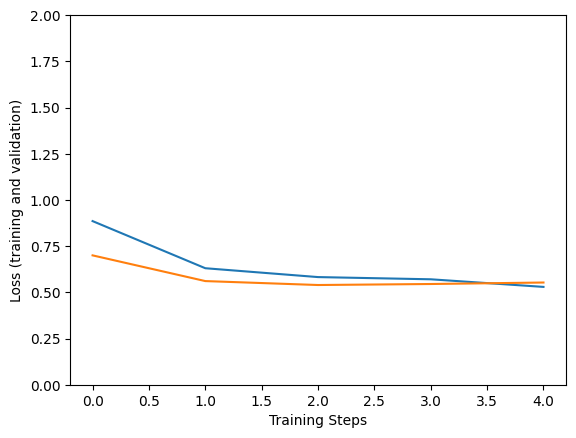

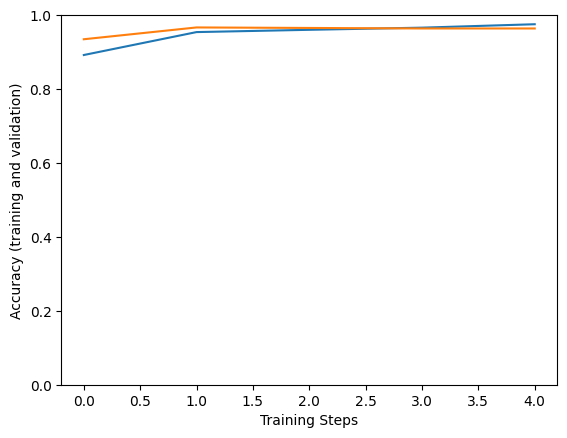

In [10]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

検証データの画像でモデルが機能するか試してみましょう。

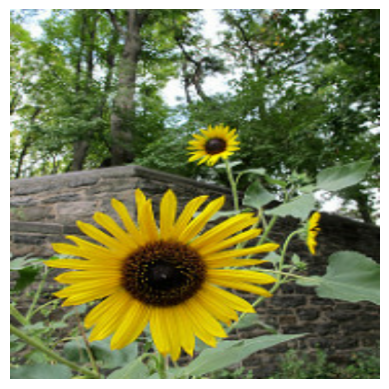

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 6s 6s/step


True label: sunflowers
Predicted label: sunflowers


In [11]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

最後に次のようにして、トレーニングされたモデルを、TF Serving または TF Lite（モバイル）用に保存することができます。

In [12]:
saved_model_path = f"/tmp/saved_flowers_model_{model_name}"
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: /tmp/saved_flowers_model_efficientnetv2-xl-21k/assets


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model_efficientnetv2-xl-21k/assets


## オプション: TensorFlow Lite にデプロイする

[TensorFlow Lite](https://www.tensorflow.org/lite) では、TensorFlow モデルをモバイルおよび IoT デバイスにデプロイすることができます。以下のコードには、トレーニングされたモデルを TF Lite に変換して、[TensorFlow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization) のポストトレーニングツールを適用する方法が示されています。最後に、結果の質を調べるために、変換したモデルを TF Lite Interpreter で実行しています。

- 最適化せずに変換すると、前と同じ結果が得られます（丸め誤差まで）。
- データなしで最適化して変換すると、モデルの重みを 8 ビットに量子化しますが、それでもニューラルネットワークアクティベーションの推論では浮動小数点数計算が使用されます。これにより、モデルのサイズが約 4 倍に縮小されるため、モバイルデバイスの CPU レイテンシが改善されます。
- 最上部の、ニューラルネットワークアクティベーションの計算は、量子化の範囲を調整するために小規模な参照データセットが提供される場合、8 ビット整数に量子化されます。モバイルデバイスでは、これにより推論がさらに高速化されるため、EdgeTPU などのアクセラレータで実行することが可能となります。

In [13]:
#@title Optimization settings
optimize_lite_model = False  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 60  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_ds for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open(f"/tmp/lite_flowers_model_{model_name}.tflite", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

2024-01-11 20:25:57.979361: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-11 20:25:57.979412: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 879, Total Ops 2180, % non-converted = 40.32 %
 * 879 ARITH ops

- arith.constant:  879 occurrences  (f32: 878, i32: 1)



  (f32: 94)
  (f32: 358)
  (f32: 80)
  (f32: 1)
  (f32: 342)
  (f32: 81)
  (f32: 342)


Wrote TFLite model of 826217852 bytes.


In [14]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TFLite Interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [15]:
#@markdown For rapid experimentation, start with a moderate number of examples.
num_eval_examples = 50  #@param {type:"slider", min:0, max:700}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_ds
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TFLite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TFLite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


TFLite model agrees with original model on 50 of 50 examples (100%).
TFLite model is accurate on 50 of 50 examples (100%).
